In [155]:
from matplotlib import pyplot as plt
import numpy as np
from skimage import data, util, transform, feature, measure, filters, metrics
from os.path import join
from PIL import Image
from skimage.filters import difference_of_gaussians

import pandas as pd

scale_fig_dim = [1, 1]
scale_fig_dim_legend_outside = [1.3, 1]
plt.style.use(['science', 'ieee', 'std-colors'])
fig, ax = plt.subplots()
size_x_inches, size_y_inches = fig.get_size_inches()
plt.close(fig)

## Define functions:

In [131]:
# ref: https://scikit-image.org/docs/dev/auto_examples/registration/plot_stitching.html

def match_locations(img0, img1, coords0, coords1, radius=5, sigma=3):
    """Match image locations using SSD minimization.

    Areas from `img0` are matched with areas from `img1`. These areas
    are defined as patches located around pixels with Gaussian
    weights.

    Parameters:
    -----------
    img0, img1 : 2D array
        Input images.
    coords0 : (2, m) array_like
        Centers of the reference patches in `img0`.
    coords1 : (2, n) array_like
        Centers of the candidate patches in `img1`.
    radius : int
        Radius of the considered patches.
    sigma : float
        Standard deviation of the Gaussian kernel centered over the patches.

    Returns:
    --------
    match_coords: (2, m) array
        The points in `coords1` that are the closest corresponding matches to
        those in `coords0` as determined by the (Gaussian weighted) sum of
        squared differences between patches surrounding each point.
    """
    y, x = np.mgrid[-radius:radius + 1, -radius:radius + 1]
    weights = np.exp(-0.5 * (x ** 2 + y ** 2) / sigma ** 2)
    weights /= 2 * np.pi * sigma * sigma

    match_list = []
    match_ssds = []
    for r0, c0 in coords0:
        roi0 = img0[r0 - radius:r0 + radius + 1, c0 - radius:c0 + radius + 1]
        roi1_list = [img1[r1 - radius:r1 + radius + 1,c1 - radius:c1 + radius + 1] for r1, c1 in coords1]
        # sum of squared differences
        ssd_list = [np.sum(weights * (roi0 - roi1) ** 2) for roi1 in roi1_list]
        
        # store
        match_ssds.append(np.min(ssd_list))
        match_list.append(coords1[np.argmin(ssd_list)])
        
    # Sean's edits:
    match_list = np.array(match_list)
    match_ssds = np.array(match_ssds)
    # return the SSD list to measure matching accuracy
    # print("Centers of reference patches, coords0: shape = {}".format(np.shape(coords0)))
    # print("Centers of candidate patches, coords1: shape = {}".format(np.shape(coords1)))
    # print("Points in coords1 that are closest to coords0, match_coords: shape = {}".format(np.shape(match_list)))
    # print("Min. SSD of match_coords: shape = {}".format(np.shape(match_ssds)))
    # print("Points in coords1 that are closest to coords0, match_coords: values = {}".format(match_list))
    # print("Min. SSD of match_coords: values = {}".format(match_ssds))

    return match_list, match_ssds

In [132]:
# function developed by Peter Li

def stitched_img(img_ref,img_added,ref_pt,pt,stitch_dir):
    # cauculate diff and cauculate the offset which is used in stitch process
    
    if stitch_dir == "H":
        # horizontally
        width = img_added.shape[1] 
        final_offset = img_ref.shape[1] 
        offset_bound = img_ref.shape[1] 
    
    if stitch_dir == "V":
        # vertically
        width = img_added.shape[0] 
        final_offset = img_ref.shape[0] 
        offset_bound = img_ref.shape[0] 
    
    diff= float("inf")
    offset = 0 # from 0 to offset_bound 
    
    
    while offset <= offset_bound:
        tem_diff = 0
        
        for i in range (len(ref_pt)-2):
            if stitch_dir == "H":
                # horizontally
                point_diff = float("inf")
                for j in range(len(ref_pt)):
                    point_diff = min(point_diff, int( abs(ref_pt[i][0] - (pt[j][0])) + 
                                                     abs(ref_pt[i][1] - (pt[j][1]- width+offset)) 
                                                    ) 
                                    )
                # sum the errors over each point
                tem_diff += point_diff
            
            if stitch_dir == "V":
                # vertically 
                point_diff = float("inf")
                for j in range(len(ref_pt)):
                    point_diff = min(point_diff, int( abs(ref_pt[i][0] - (pt[j][0]- width+offset)) + 
                                                     abs(ref_pt[i][1] - (pt[j][1])) 
                                                    ) 
                                    ) 
                # sum the errors over each point 
                tem_diff += point_diff
            

        # capture the global min
        if tem_diff<diff:
            diff = tem_diff
            final_offset = offset
            
        offset += 1
        
    # Sean edits:
    # print("Stitching Results: Optimal offset = {} pixels w/ diff {}".format(final_offset, diff))
    
    
    # stitched image
    if stitch_dir == "H":
        # horizontal stitch
        output_img = np.zeros([max(img_ref.shape[0],img_added.shape[0]),img_ref.shape[1]+img_added.shape[1]-final_offset] ,dtype=np.uint16)   
        output_img[0:img_added.shape[0],0:img_added.shape[1]]=img_added
        output_img[0:img_ref.shape[0],img_added.shape[1]:] = img_ref[0:img_ref.shape[0],final_offset:img_ref.shape[1]]
    
    if stitch_dir == "V":
        # vertical stitch
        output_img = np.zeros([img_ref.shape[0]+img_added.shape[0]-final_offset,max(img_ref.shape[1],img_added.shape[1])] ,dtype=np.uint16)   
        output_img[0:img_added.shape[0],0:img_added.shape[1]]=img_added
        output_img[img_added.shape[0]:,0:img_ref.shape[1]] = img_ref[final_offset:img_ref.shape[1],0:img_ref.shape[1]]
    
    # print("output_img: shape = {}".format(np.shape(output_img)))
    # print("final_offset: shape = {}".format(np.shape(final_offset)))
    # print("diff: shape = {}".format(np.shape(diff)))
    
    return (output_img, final_offset, diff)

# Test harness: stitching accuracy

In [217]:
def evaluate_stitching(true_image_length, true_image_width, true_percent_overlap, true_shift, 
                       manual_input, denominate_faction, min_dist, direction,
                       harris_detector, hessian_detector, DoG_detector, input_detector):
    
    # image inputs
    fp = '/Users/mackenzie/Desktop/ece278a/skimage/full_field/overlap_{}percent'.format(true_percent_overlap)

    if direction == "H":
        # horizontal
        path1 = join(fp, 'image_i0_j4.tif')
        path2 = join(fp, 'image_i1_j4.tif')
        path3 = join(fp, 'image_i2_j4.tif')
        path4 = join(fp, 'image_i3_j4.tif')
        path5 = join(fp, 'image_i4_j4.tif')
        path6 = join(fp, 'image_i5_j4.tif')
        path7 = join(fp, 'image_i6_j4.tif') 
    if direction == "V":    
        # vertical
        path1 = join(fp, 'image_i0_j0.tif')
        path2 = join(fp, 'image_i0_j1.tif')
        path3 = join(fp, 'image_i0_j2.tif')
        path4 = join(fp, 'image_i0_j3.tif')
        path5 = join(fp, 'image_i0_j4.tif')
        path6 = join(fp, 'image_i0_j5.tif')
        path7 = join(fp, 'image_i0_j6.tif')


    # print setting
    show_keypoints_extract_infor = False
    show_match_points_infor = False
    show_iterative_result = False

    # exclude invalid setting
    if direction != "V" and direction != "H": 
        raise AssertionError("[error] stitch direction setting wrong")
    if harris_detector+hessian_detector+DoG_detector !=1 : 
        raise AssertionError("[error] detector setting wrong") 

    # Open the image form working directory
    img_list = []

    image = Image.open(path1)
    img = np.array(image)
    img_list.append(img)
    image = Image.open(path2)
    img = np.array(image)
    img_list.append(img)
    image = Image.open(path3)
    img = np.array(image)
    img_list.append(img)
    image = Image.open(path4)
    img = np.array(image)
    img_list.append(img)
    image = Image.open(path5)
    img = np.array(image)
    img_list.append(img)
    
    if true_percent_overlap == 50:
        image = Image.open(path6)
        img = np.array(image)
        img_list.append(img)
        image = Image.open(path7)
        img = np.array(image)
        img_list.append(img)
        

    # main program
    # stitch the image iterativly

    image_number = 0
    results = []
    while(len(img_list)>=2):

        # ----------------------- STEP 1: DETECT PARTICLES -----------------------
        corner_list = []
        for i in range(0,2,1):
            if harris_detector:
                corner_list.append(feature.corner_peaks(feature.corner_harris(img_list[i]), 
                                                        threshold_rel=0.001, 
                                                        min_distance=min_dist))
                input_detector = 'Harris'

            if hessian_detector:
                corner_list.append(feature.corner_peaks(feature.hessian_matrix_det(img_list[i]), 
                                                        threshold_rel=0.2, 
                                                        min_distance=min_dist))
                input_detector = 'Hessian'

            if DoG_detector:
                # Edit by Sean:
                    # high_sigma: from skimage.difference_of_gaussians notes, high_sigma is generally 1.6X low sigma.
                    # Sean changed high_sigma from 2.6 to 3.2 to use the suggested low_sigma*1.6 ratio.
                corner_list.append(feature.corner_peaks(difference_of_gaussians(image=img_list[i],
                                                                                low_sigma=2,
                                                                                high_sigma=3.2), 
                                                        threshold_rel=0.6, 
                                                        min_distance=min_dist))
                input_detector = 'DoG'



        # ----------------------- STEP 2: SORT PARTICLES BY LOCATION -----------------------

        if direction == "H":
            # horizontally
            corner_list[0] = sorted(corner_list[0],key=lambda s:s[1], reverse=True )
            corner_list[1] = sorted(corner_list[1],key=lambda s:s[1])

        if direction == "V":
            # vertically
            corner_list[0] = sorted(corner_list[0],key=lambda s:s[0], reverse=True )
            corner_list[1] = sorted(corner_list[1],key=lambda s:s[0])


        # ----------------------- STEP 3: KEY POINT SELECTION -----------------------

        calc_fraction = int(len(corner_list[1])/denominate_faction)+1
        fraction = manual_input

        img0 = img_list[0]
        coords0 = corner_list[0][0:manual_input]


        # ----------------------- STEP 4: KEY POINT MATCHING -----------------------

        matching_corners=[]
        matching_ssds=[]
        for i in range(0,2,1):
            matched_corners, matched_corner_ssds = match_locations(img0, 
                                                                   img_list[i], 
                                                                   coords0, 
                                                                   corner_list[i][0:fraction], 
                                                                   min_dist)
            matching_corners.append(matched_corners)
            matching_ssds.append(matched_corner_ssds)


        # ----------------------- STEP 5: RESULTS VISUALIZATION -----------------------
        # print("Number of particles detected = {}".format(len(corner_list[1])))
        # print("Calculated fraction is {}".format(calc_fraction))
        # print("Manual input is {}".format(manual_input))
        # print("New fraction is {}".format(fraction))

        # print("matching corners: shape = {}".format(np.shape(matching_corners)))
        # matching corners: [image #, particle x coord., particle y coord]
        # print("matching ssds: shape = {}".format(np.shape(matching_ssds)))
        # matching ssds: [image #, SSD of particle at that index]
        # print("matching ssds: sum of values = {}".format(np.sum(matching_ssds)))

        # call self-develope function to stitch image
        sti, final_offset, diff = stitched_img(img_list[1],img_list[0],matching_corners[1],matching_corners[0],direction)



        # ----------------------- STEP 6: RESULTS OUTPUTS -----------------------
        
        # ----- Inputs:
        # true_image_length
        # true_image_width
        # true_percent_overlap
        # true_shift
        
        input_direction = direction
        input_num_keypoints = manual_input
        input_min_distance = min_dist
        
        # ----- Outputs:
        # image_number
        num_keypoints_detected = len(coords0)
        num_keypoints_matching = np.shape(matching_corners)[1]
        sum_ssd = np.round(np.sum(matching_ssds), 0)
        calc_shift = final_offset
        calc_diff = diff
        calc_image_length = np.shape(sti)[0]
        calc_image_width = np.shape(sti)[1]


        result = np.array([true_image_length, true_image_width, true_percent_overlap, true_shift,
                            input_direction, input_detector, input_num_keypoints, input_min_distance, 
                            image_number, num_keypoints_detected, num_keypoints_matching, sum_ssd, 
                            calc_shift, calc_diff, calc_image_length, calc_image_width])
        results.append(result)
        

        # ----------------------- STEP 7: ITERATE TO NEXT IMAGE -----------------------
        img_list[1] = sti
        img_list.pop(0)
        image_number += 1
        
    return results


---

# Evaluate stitching

In [245]:
# Trues
true_image_length = 1024
true_image_width = 256
true_percent_overlap = 50
true_shift = 128

# parameter setting
manual_input = 15
denominate_faction = 3.5    # using (1/deno_faction) portion of extracted points to match
min_dist = 5                
direction = "V"

harris_detector = False
hessian_detector = False
DoG_detector = True
input_detector = 'temp string'


In [246]:
dir_results = '/Users/mackenzie/Desktop/ece278a/results'
save_path = '/Users/mackenzie/Desktop/ece278a/figs'
manual_inputs = [3, 4, 5, 7, 10, 15, 20]

results = []
dfs = []
for mi in manual_inputs:
    """
    result = evaluate_stitching(true_image_length, true_image_width, true_percent_overlap, true_shift, 
                           manual_input, denominate_faction, min_dist, direction,
                           harris_detector, hessian_detector, DoG_detector, input_detector)
    """
    result = evaluate_stitching(true_image_length, true_image_width, true_percent_overlap, true_shift, 
                           mi, denominate_faction, min_dist, direction,
                           harris_detector, hessian_detector, DoG_detector, input_detector)
    results.append(result)
    print(np.shape(results))
    
    # store individual dataframes for plotting
    res = np.array(result)
    res = res.reshape(-1, res.shape[-1])
    dfr = pd.DataFrame(res, 
                  columns=['true_image_length', 'true_image_width', 'true_percent_overlap', 'true_shift',
                          'input_direction', 'input_detector', 'input_num_keypoints', 'input_min_distance',
                          'image_number', 'num_keypoints_detected', 'num_keypoints_matching', 'sum_ssd',
                          'calc_shift', 'calc_diff', 'calc_image_length', 'calc_image_width'])
    dfs.append(dfr)
    
    # store variables for file naming
    inp_dir, dtctr = res[0, 4], res[0, 5]
    

    
results = np.array(results)
results_reshaped = results.reshape(-1, results.shape[-1])
print(np.shape(results_reshaped))

df = pd.DataFrame(results_reshaped, 
                  columns=['true_image_length', 'true_image_width', 'true_percent_overlap', 'true_shift',
                          'input_direction', 'input_detector', 'input_num_keypoints', 'input_min_distance',
                          'image_number', 'num_keypoints_detected', 'num_keypoints_matching', 'sum_ssd',
                          'calc_shift', 'calc_diff', 'calc_image_length', 'calc_image_width'])

df.to_excel(join(dir_results, '{}_{}_sweep_input_num_keypoints.xlsx'.format(dtctr, inp_dir)))
# df

(1, 6, 16)
(2, 6, 16)
(3, 6, 16)
(4, 6, 16)
(5, 6, 16)
(6, 6, 16)
(7, 6, 16)
(42, 16)


---

## Plot: sweep input_num_keypoints

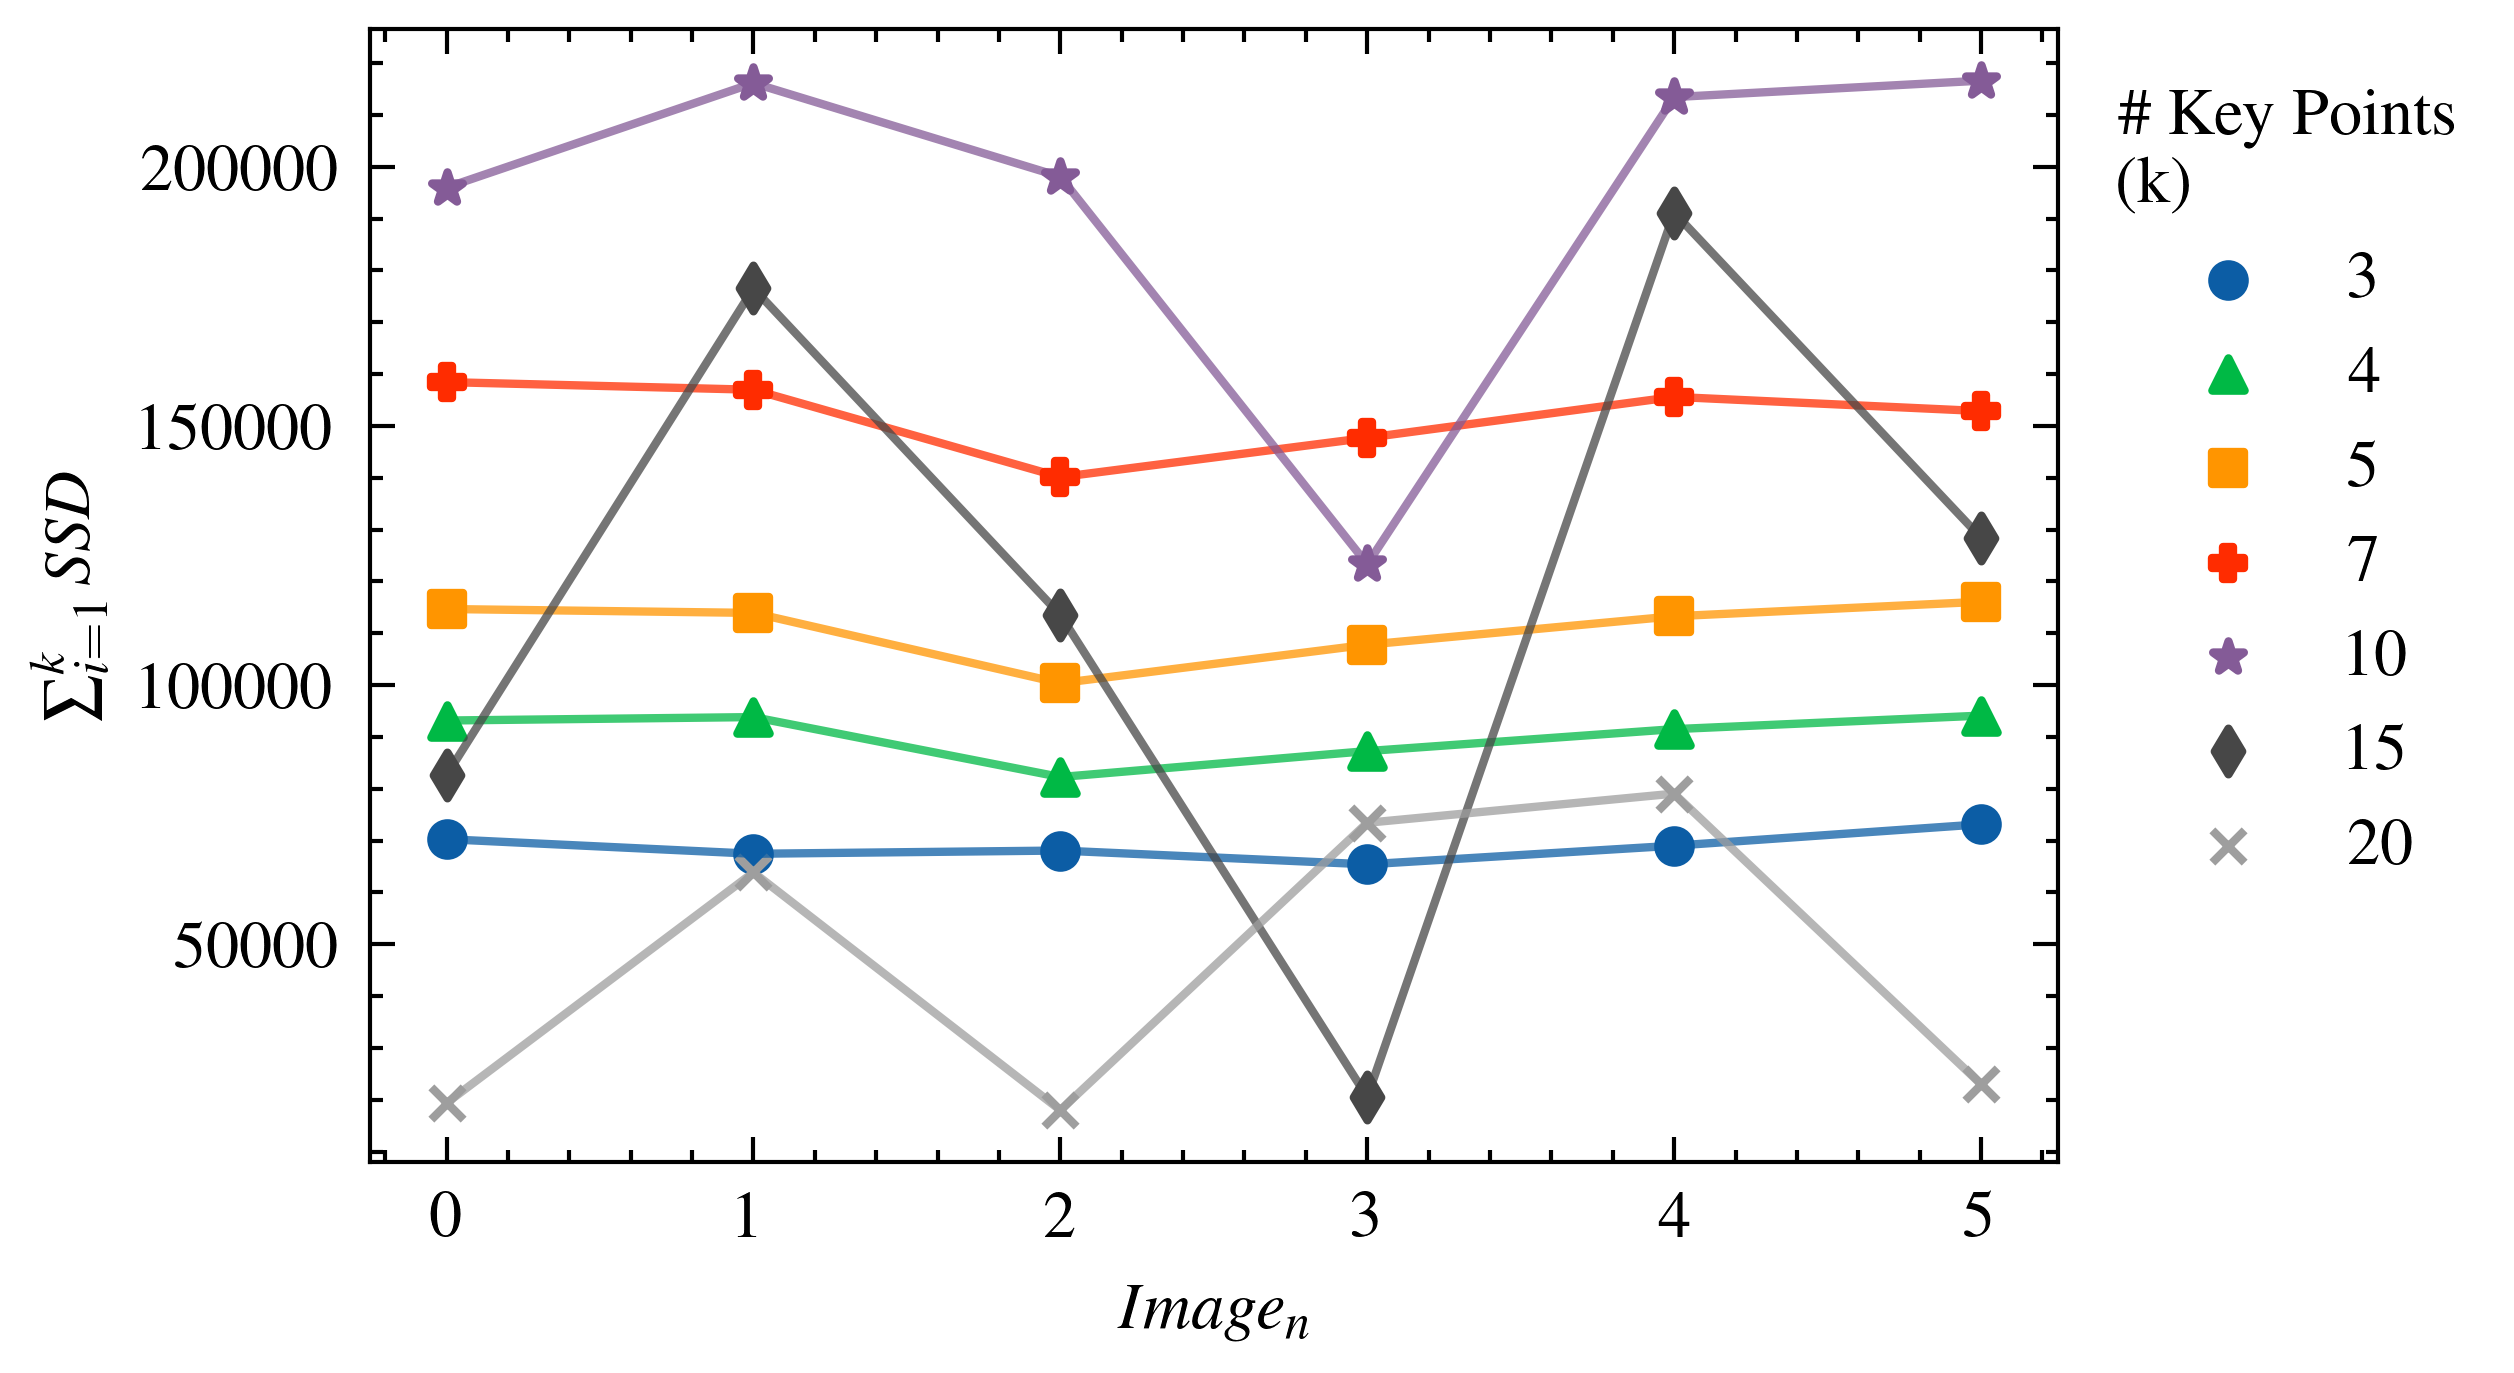

In [247]:
# plot sum_ssd(input_num_keypoints, image_number)

labels = manual_inputs = [3, 4, 5, 7, 10, 15, 20]
markers = ['o', '^', 's', 'P', '*', 'd', 'x']

fig, ax = plt.subplots(figsize=(size_x_inches*1.1, size_y_inches))

for lbl, dft, mrkr in zip(labels, dfs, markers):
    
    dft = dft.astype({"image_number": int, "sum_ssd": float})
    
    ax.plot(dft.image_number, dft.sum_ssd, alpha=0.75)
    ax.scatter(dft.image_number, dft.sum_ssd, s=15, marker=mrkr, label=lbl)

ax.set_xlabel(r'$Image_{n}$')
ax.set_ylabel(r'$ \sum_{i=1}^{k} SSD $')
ax.legend(loc='upper left', bbox_to_anchor=(1,1), title='\# Key Points \n (k)')
plt.savefig(join(save_path, 'sweep_num_keypoints_plot_sum_SSD_of_image_number'))
plt.show()

## Plot: average SSD

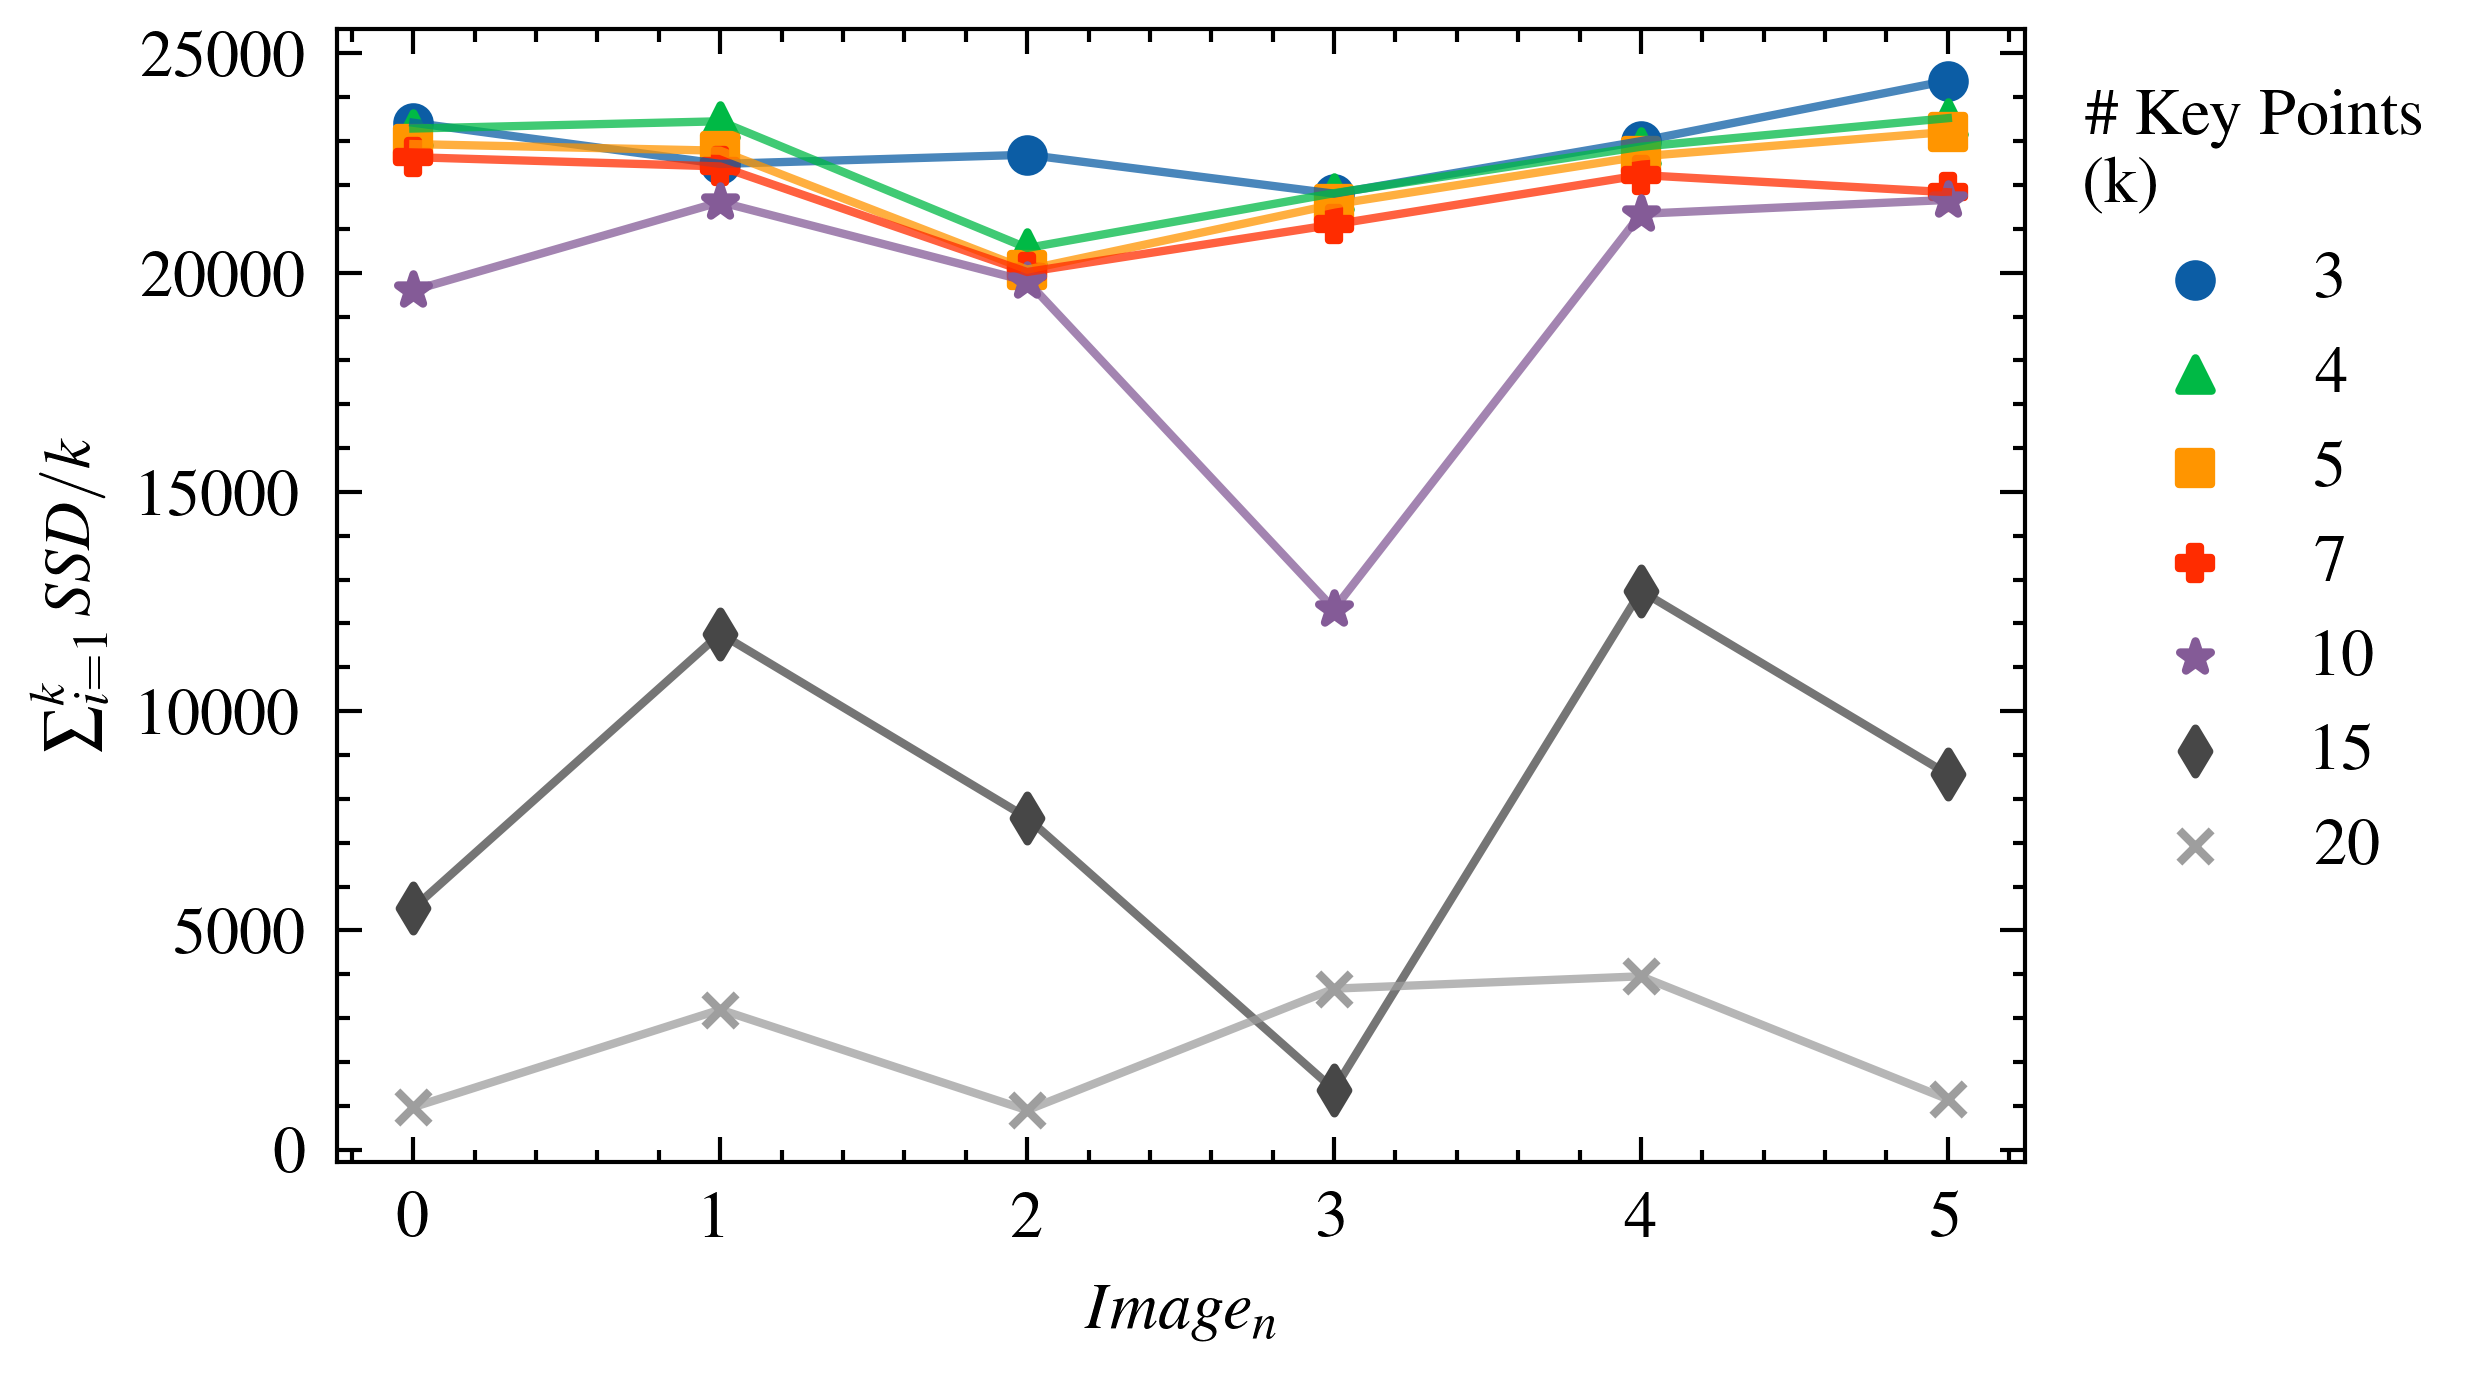

In [248]:
# plot sum_ssd(input_num_keypoints, image_number)

labels = manual_inputs = [3, 4, 5, 7, 10, 15, 20]
markers = ['o', '^', 's', 'P', '*', 'd', 'x']

fig, ax = plt.subplots(figsize=(size_x_inches*1.1, size_y_inches))

for lbl, dft, mrkr in zip(labels, dfs, markers):
    
    dft = dft.astype({"image_number": int, "sum_ssd": float})
    
    ax.plot(dft.image_number, dft.sum_ssd / lbl, alpha=0.75)
    ax.scatter(dft.image_number, dft.sum_ssd / lbl, s=15, marker=mrkr, label=lbl)

ax.set_xlabel(r'$Image_{n}$')
ax.set_ylabel(r'$ \sum_{i=1}^{k} SSD/k $')
ax.legend(loc='upper left', bbox_to_anchor=(1,1), title='\# Key Points \n (k)')
plt.savefig(join(save_path, 'sweep_num_keypoints_plot_norm_sum_SSD_of_image_number'))
plt.show()

## Plot: shift error

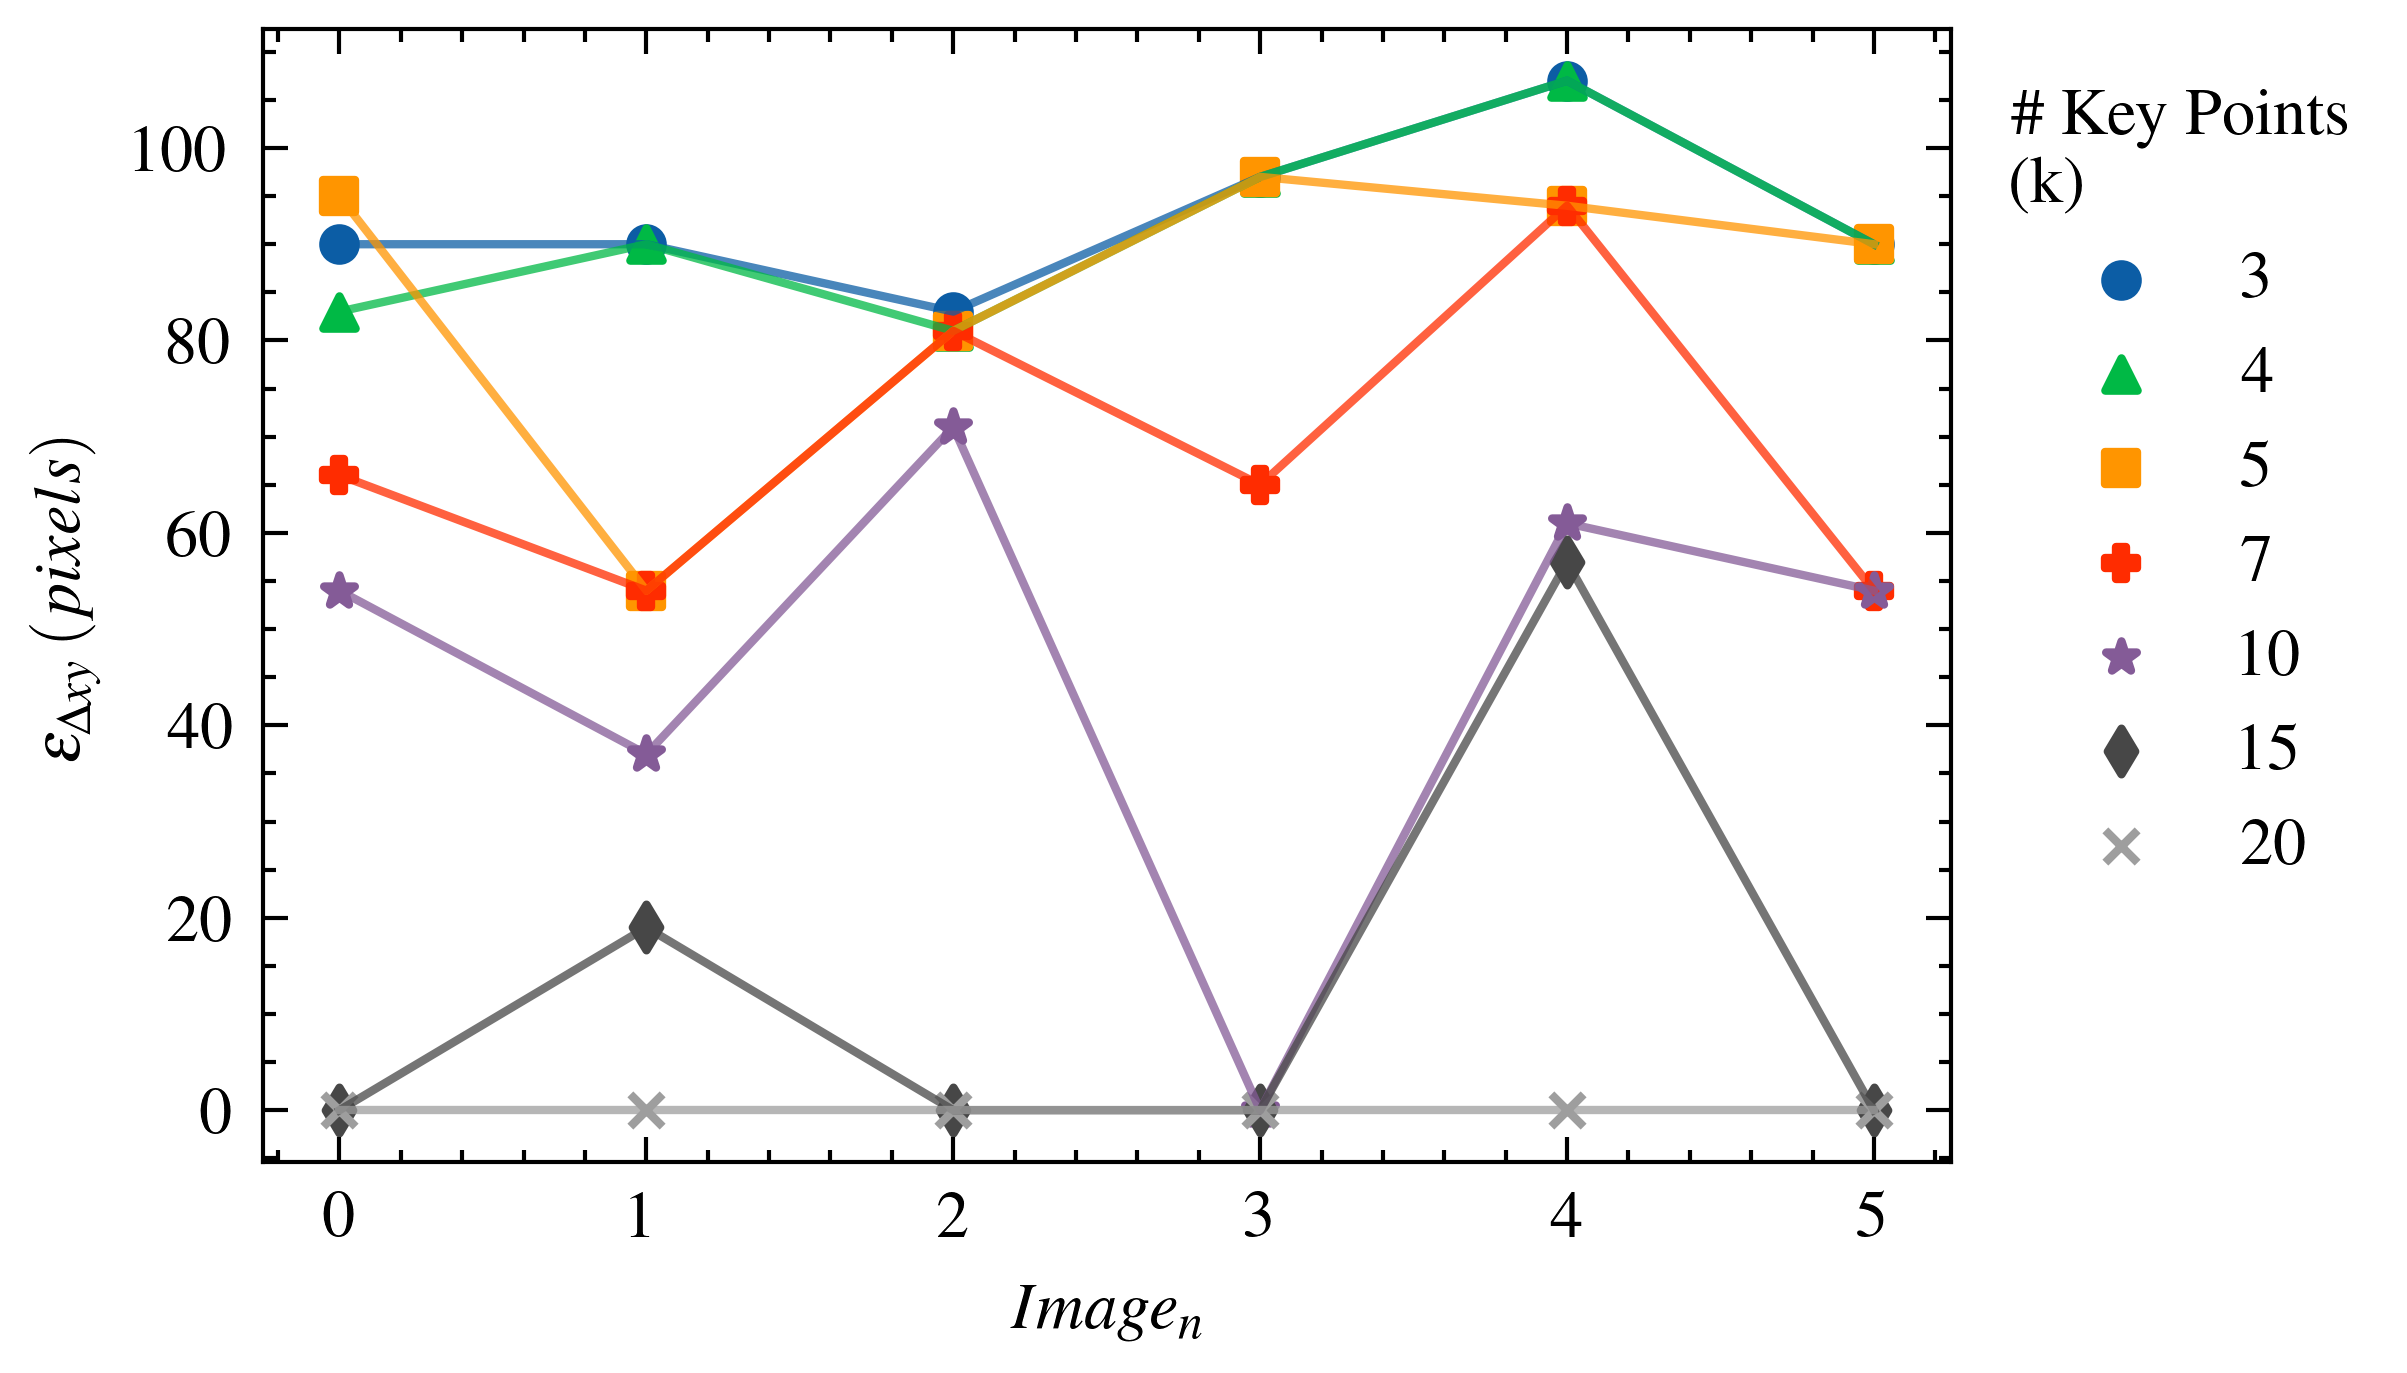

In [249]:
# plot sum_ssd(input_num_keypoints, image_number)

labels = [3, 4, 5, 7, 10, 15, 20]
markers = ['o', '^', 's', 'P', '*', 'd', 'x']

fig, ax = plt.subplots(figsize=(size_x_inches*1.1, size_y_inches))

for lbl, dft, mrkr in zip(labels, dfs, markers):
    
    dft = dft.astype({"image_number": int, "true_shift": float, "calc_shift": float})
    
    dft['shift_error'] = np.abs(dft.true_shift - dft.calc_shift)
    
    ax.plot(dft.image_number, dft.shift_error, alpha=0.75)
    ax.scatter(dft.image_number, dft.shift_error, s=15, marker=mrkr, label=lbl)

ax.set_xlabel(r'$Image_{n}$')
ax.set_ylabel(r'$ \epsilon_{\Delta xy} \: (pixels)$')
ax.legend(loc='upper left', bbox_to_anchor=(1,1), title='\# Key Points \n (k)')
plt.savefig(join(save_path, 'sweep_num_keypoints_plot_shift_error_of_image_number'))
plt.show()

---

# Compare 50% to 25% overlap

In [254]:
# Trues
true_image_length = 1024
true_image_width = 256


# parameter setting
manual_input = 15
denominate_faction = 3.5    # using (1/deno_faction) portion of extracted points to match
min_dist = 5                
direction = "V"

harris_detector = False
hessian_detector = False
DoG_detector = True
input_detector = 'temp string'

results = []
results_50p = []
dfs = []

# BEST CASE - 25 PERCENT - DoG with 10 matching points:
true_percent_overlap = 25
true_shift = 64
manual_input = 10
# vertical
direction = "V"
result = evaluate_stitching(true_image_length, true_image_width, true_percent_overlap, true_shift, 
                           manual_input, denominate_faction, min_dist, direction,
                           harris_detector, hessian_detector, DoG_detector, input_detector)
results.append(result)
res = np.array(result)
res = res.reshape(-1, res.shape[-1])
dfr_dog_v = pd.DataFrame(res, 
              columns=['true_image_length', 'true_image_width', 'true_percent_overlap', 'true_shift',
                      'input_direction', 'input_detector', 'input_num_keypoints', 'input_min_distance',
                      'image_number', 'num_keypoints_detected', 'num_keypoints_matching', 'sum_ssd',
                      'calc_shift', 'calc_diff', 'calc_image_length', 'calc_image_width'])
# horizontal
direction = "H"
result = evaluate_stitching(true_image_length, true_image_width, true_percent_overlap, true_shift, 
                           manual_input, denominate_faction, min_dist, direction,
                           harris_detector, hessian_detector, DoG_detector, input_detector)
results.append(result)
res = np.array(result)
res = res.reshape(-1, res.shape[-1])
dfr_dog_h = pd.DataFrame(res, 
              columns=['true_image_length', 'true_image_width', 'true_percent_overlap', 'true_shift',
                      'input_direction', 'input_detector', 'input_num_keypoints', 'input_min_distance',
                      'image_number', 'num_keypoints_detected', 'num_keypoints_matching', 'sum_ssd',
                      'calc_shift', 'calc_diff', 'calc_image_length', 'calc_image_width'])


# combine horizontal and vertical
results = np.array(results)
results_reshaped = results.reshape(-1, results.shape[-1])
print(np.shape(results_reshaped))

df = pd.DataFrame(results_reshaped, 
                  columns=['true_image_length', 'true_image_width', 'true_percent_overlap', 'true_shift',
                          'input_direction', 'input_detector', 'input_num_keypoints', 'input_min_distance',
                          'image_number', 'num_keypoints_detected', 'num_keypoints_matching', 'sum_ssd',
                          'calc_shift', 'calc_diff', 'calc_image_length', 'calc_image_width'])

# groupby
df = df.drop(columns=['input_direction', 'input_detector'])
df = df.apply(pd.to_numeric) # convert all columns to float
df = df.groupby('image_number').mean()
dfs.append(df)

df.to_excel(join(dir_results, '25p_DoG_HV_sweep_input_num_keypoints.xlsx'.format(dtctr, inp_dir)))


# ------------------------------------------------------------------------------------------------------


# BEST CASE - 25 PERCENT - DoG with 10 matching points:
true_percent_overlap = 50
true_shift = 128
manual_input = 20
# vertical
direction = "V"
result = evaluate_stitching(true_image_length, true_image_width, true_percent_overlap, true_shift, 
                           manual_input, denominate_faction, min_dist, direction,
                           harris_detector, hessian_detector, DoG_detector, input_detector)
results_50p.append(result)
res = np.array(result)
res = res.reshape(-1, res.shape[-1])
dfr_dog_v = pd.DataFrame(res, 
              columns=['true_image_length', 'true_image_width', 'true_percent_overlap', 'true_shift',
                      'input_direction', 'input_detector', 'input_num_keypoints', 'input_min_distance',
                      'image_number', 'num_keypoints_detected', 'num_keypoints_matching', 'sum_ssd',
                      'calc_shift', 'calc_diff', 'calc_image_length', 'calc_image_width'])
# horizontal
direction = "H"
result = evaluate_stitching(true_image_length, true_image_width, true_percent_overlap, true_shift, 
                           manual_input, denominate_faction, min_dist, direction,
                           harris_detector, hessian_detector, DoG_detector, input_detector)
results_50p.append(result)
res = np.array(result)
res = res.reshape(-1, res.shape[-1])
dfr_dog_h = pd.DataFrame(res, 
              columns=['true_image_length', 'true_image_width', 'true_percent_overlap', 'true_shift',
                      'input_direction', 'input_detector', 'input_num_keypoints', 'input_min_distance',
                      'image_number', 'num_keypoints_detected', 'num_keypoints_matching', 'sum_ssd',
                      'calc_shift', 'calc_diff', 'calc_image_length', 'calc_image_width'])


# combine horizontal and vertical
results_50p = np.array(results_50p)
results_reshaped = results_50p.reshape(-1, results_50p.shape[-1])
print(np.shape(results_reshaped))

df = pd.DataFrame(results_reshaped, 
                  columns=['true_image_length', 'true_image_width', 'true_percent_overlap', 'true_shift',
                          'input_direction', 'input_detector', 'input_num_keypoints', 'input_min_distance',
                          'image_number', 'num_keypoints_detected', 'num_keypoints_matching', 'sum_ssd',
                          'calc_shift', 'calc_diff', 'calc_image_length', 'calc_image_width'])

# groupby
df = df.drop(columns=['input_direction', 'input_detector'])
df = df.apply(pd.to_numeric) # convert all columns to float
df = df.groupby('image_number').mean()
dfs.append(df)

df.to_excel(join(dir_results, '50p_DoG_HV_sweep_input_num_keypoints.xlsx'.format(dtctr, inp_dir)))

(8, 16)
(12, 16)


# Plots

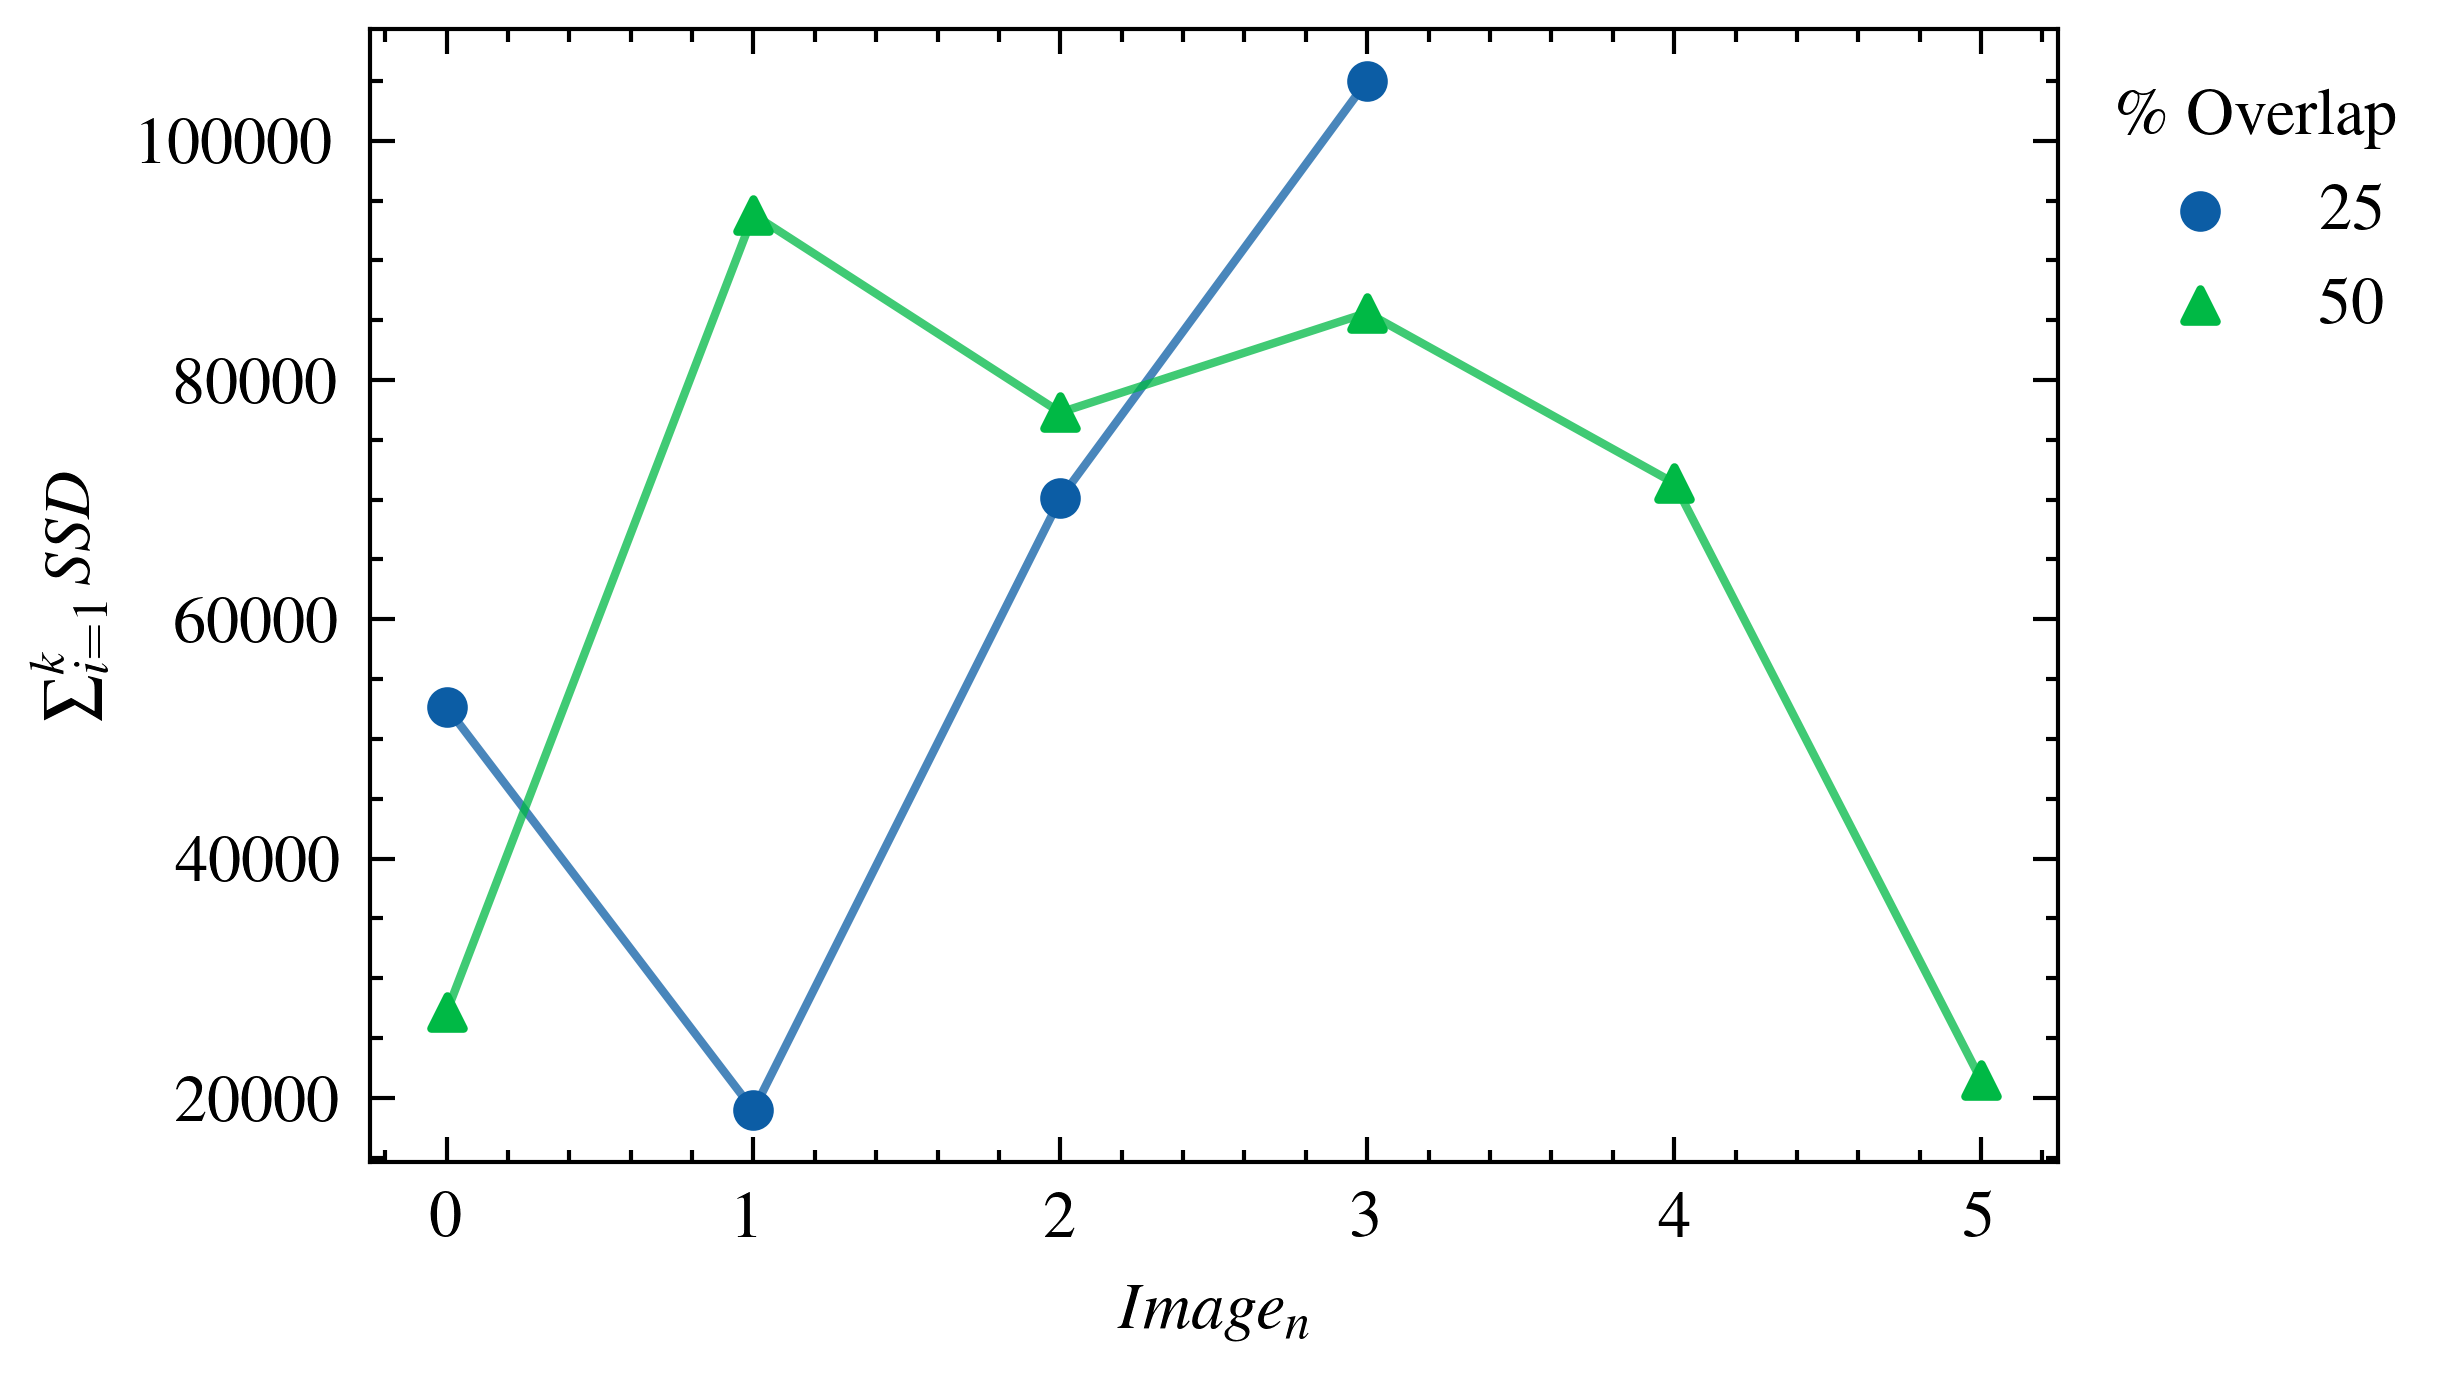

In [263]:
# plot sum_ssd(input_num_keypoints, image_number)

labels = manual_inputs = [25, 50]
markers = ['o', '^', 's', 'P', '*', 'd', 'x']

fig, ax = plt.subplots(figsize=(size_x_inches*1.1, size_y_inches))

for lbl, dft, mrkr in zip(labels, dfs, markers):
    
    dft = dft.reset_index()
    dft = dft.astype({"image_number": int, "sum_ssd": float})
    
    ax.plot(dft.image_number, dft.sum_ssd, alpha=0.75)
    ax.scatter(dft.image_number, dft.sum_ssd, s=15, marker=mrkr, label=lbl)

ax.set_xlabel(r'$Image_{n}$')
ax.set_ylabel(r'$ \sum_{i=1}^{k} SSD $')
ax.legend(loc='upper left', bbox_to_anchor=(1,1), title='\% Overlap')
plt.savefig(join(save_path, 'sweep_num_keypoints_plot_sum_SSD_of_image_number'))
plt.show()

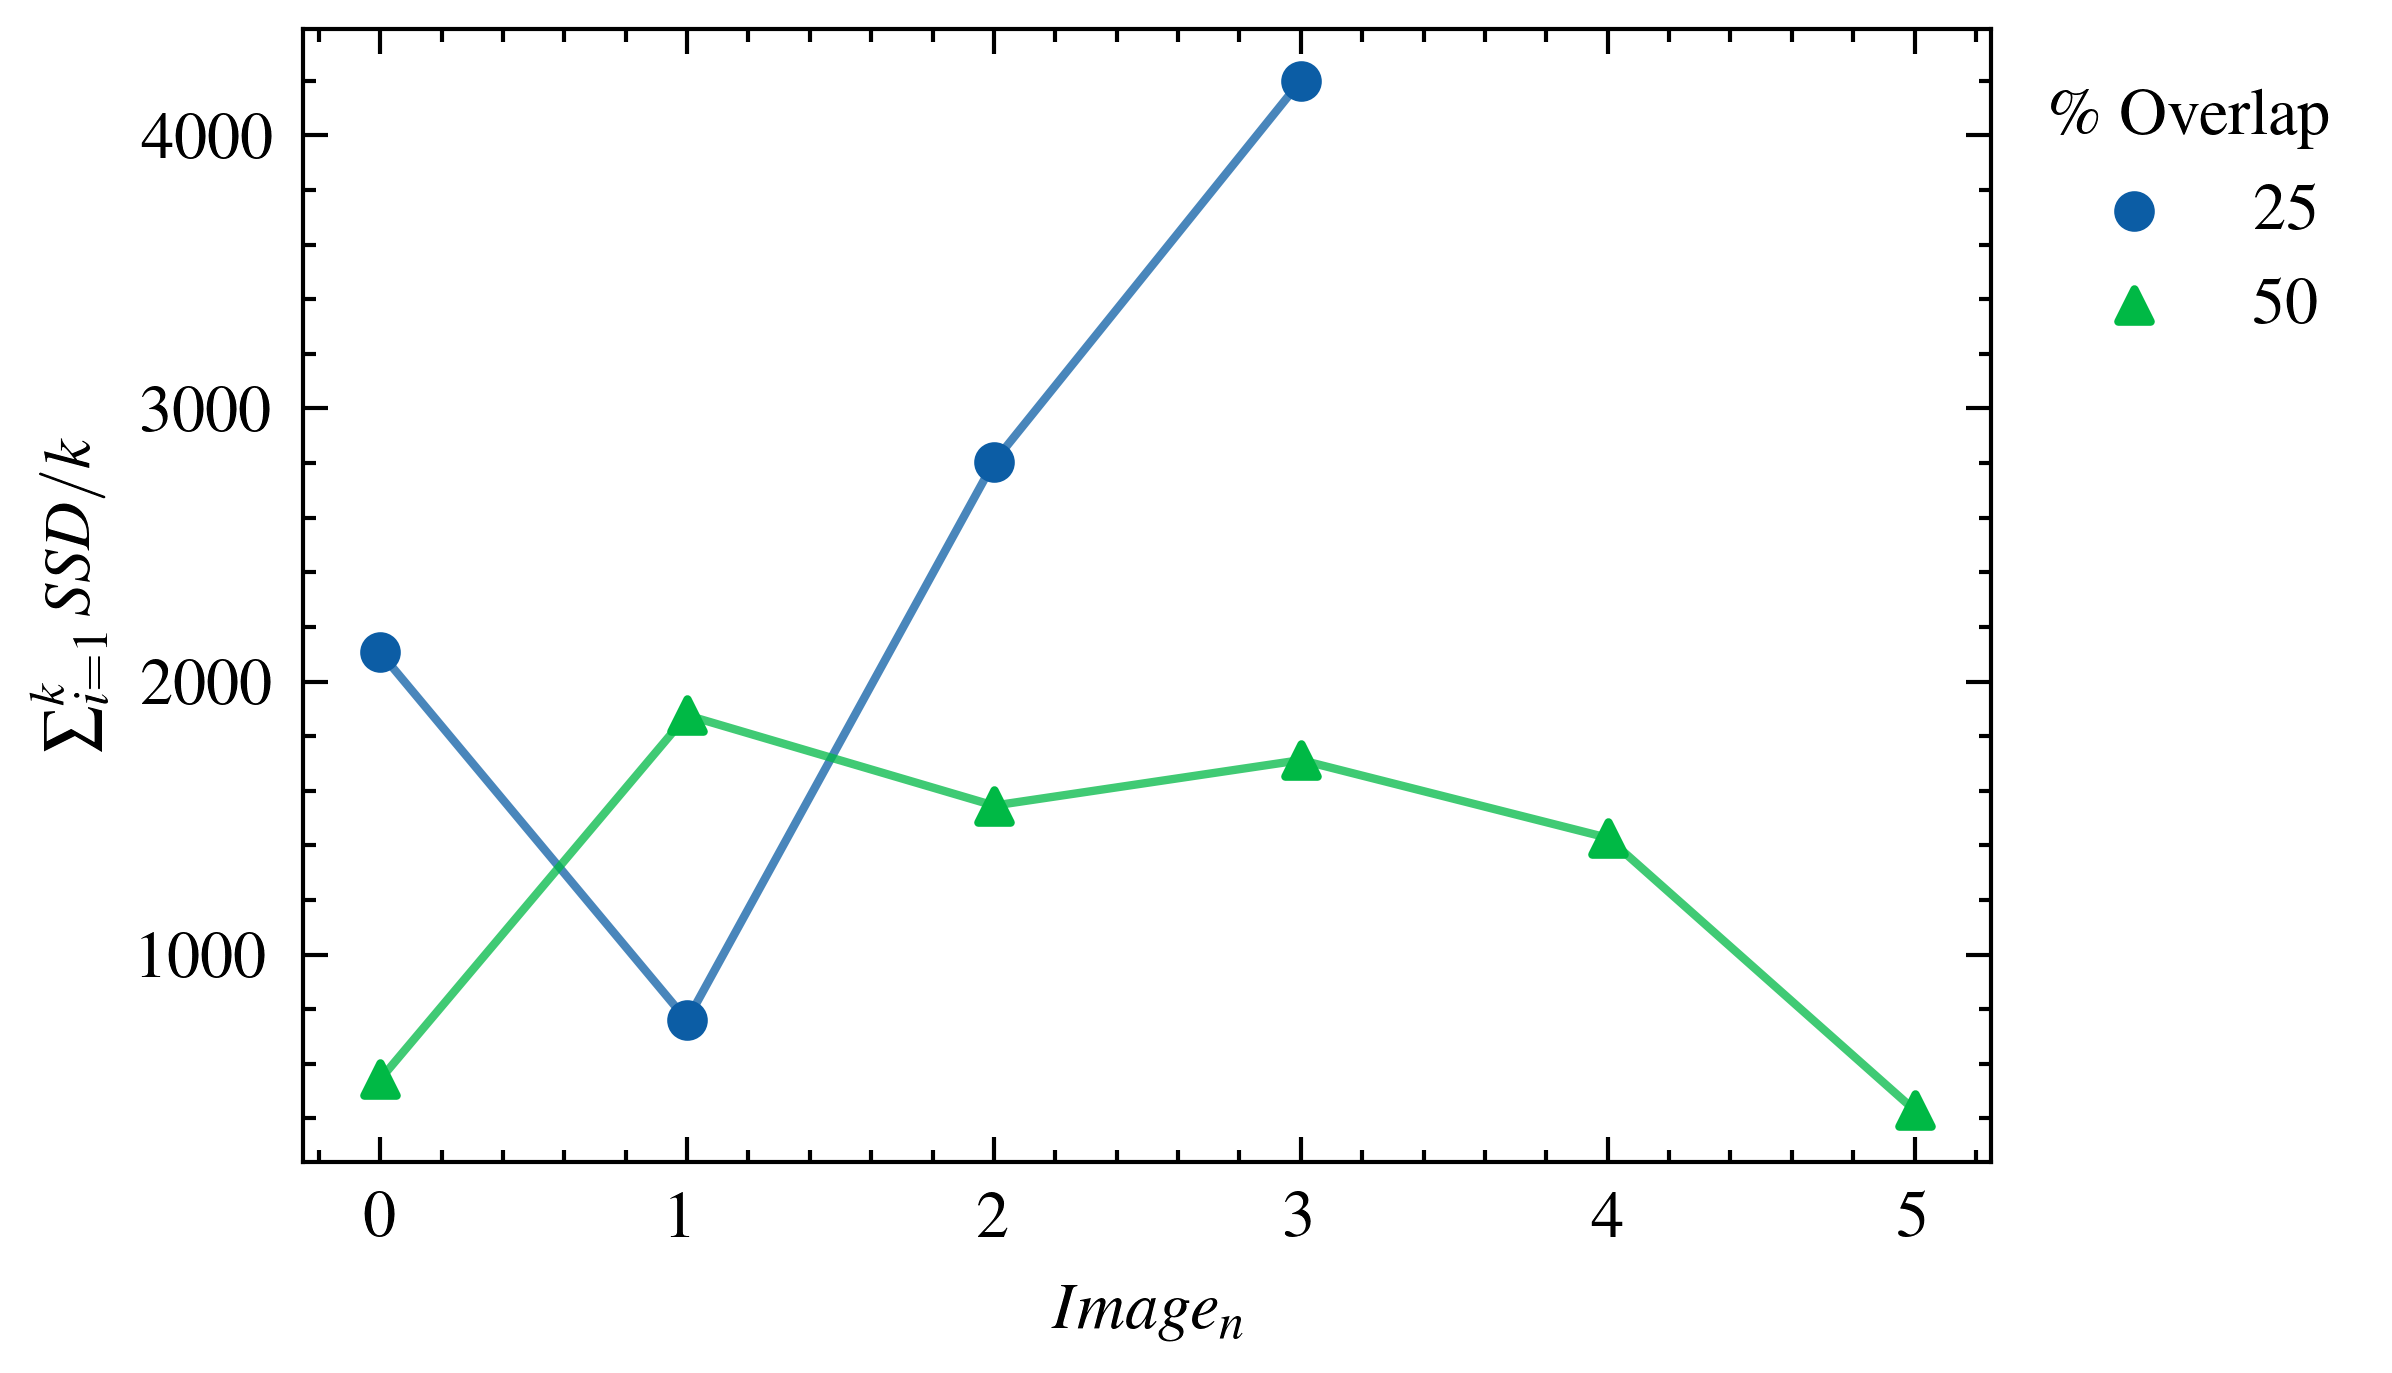

In [260]:
# plot sum_ssd(input_num_keypoints, image_number)

labels = manual_inputs = [25, 50]
markers = ['o', '^', 's', 'P', '*', 'd', 'x']

fig, ax = plt.subplots(figsize=(size_x_inches*1.1, size_y_inches))

for lbl, dft, mrkr in zip(labels, dfs, markers):
    
    dft = dft.reset_index()
    dft = dft.astype({"image_number": int, "sum_ssd": float})
    
    ax.plot(dft.image_number, dft.sum_ssd / lbl, alpha=0.75)
    ax.scatter(dft.image_number, dft.sum_ssd / lbl, s=15, marker=mrkr, label=lbl)

ax.set_xlabel(r'$Image_{n}$')
ax.set_ylabel(r'$ \sum_{i=1}^{k} SSD/k $')
ax.legend(loc='upper left', bbox_to_anchor=(1,1), title='\% Overlap')
plt.savefig(join(save_path, 'sweep_num_keypoints_plot_norm_sum_SSD_of_image_number'))
plt.show()

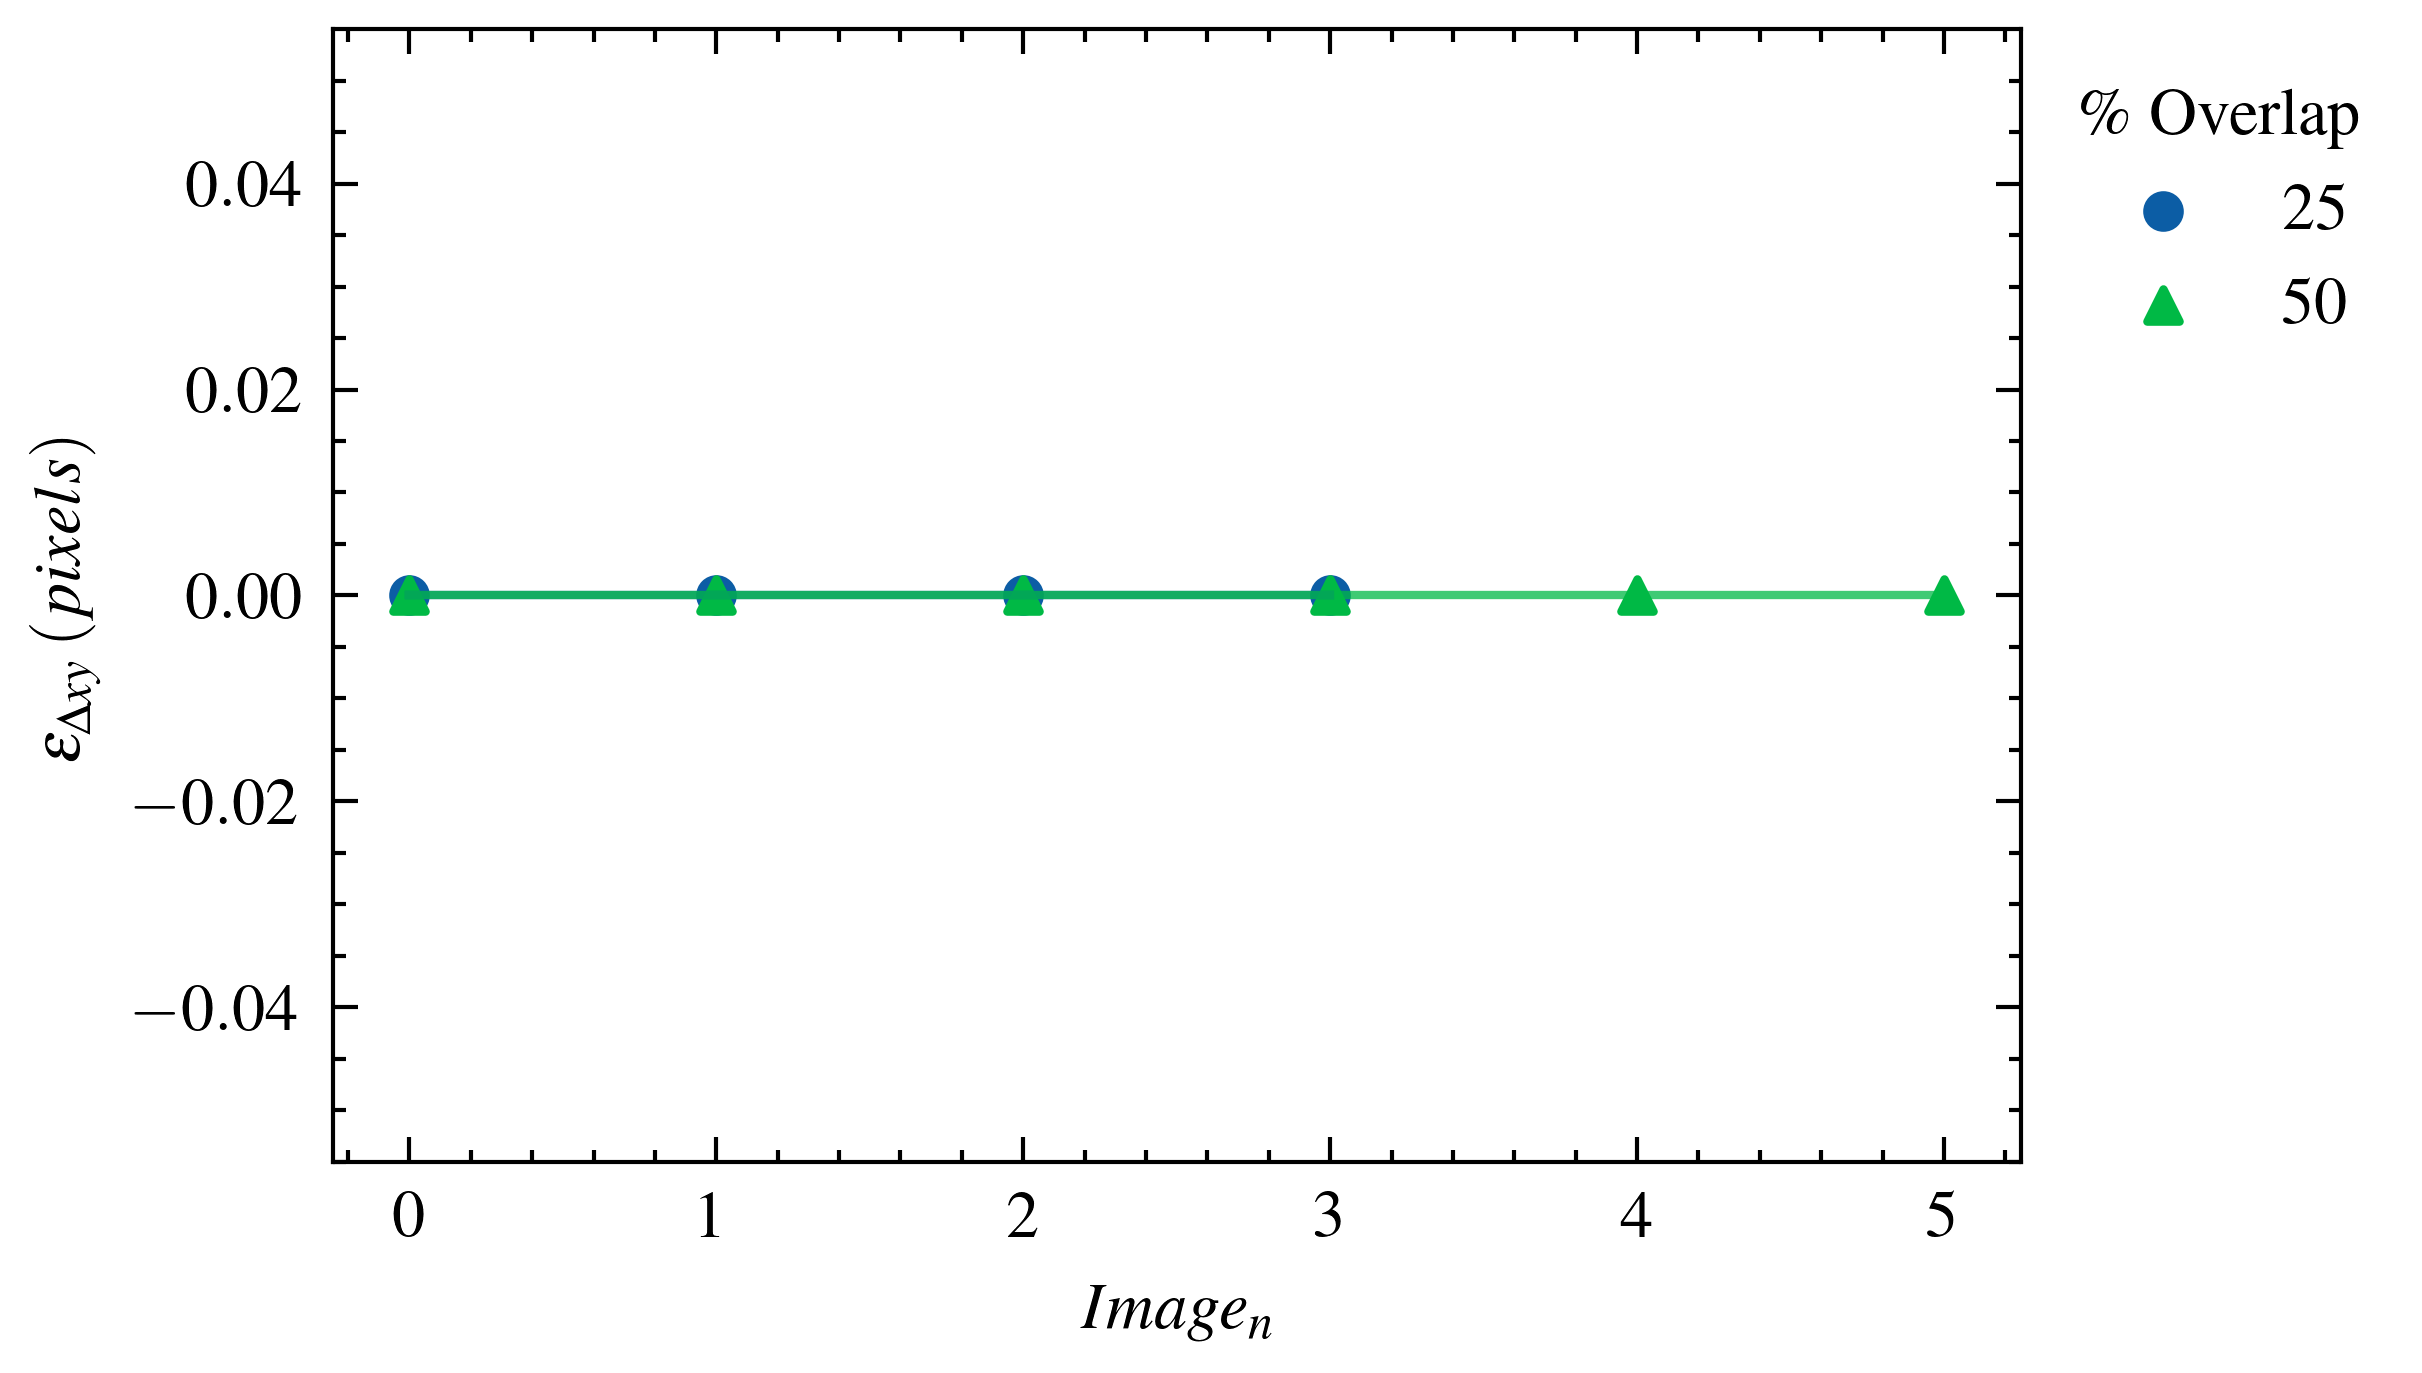

In [261]:
# plot sum_ssd(input_num_keypoints, image_number)

labels = [25, 50]
markers = ['o', '^', 's', 'P', '*', 'd', 'x']

fig, ax = plt.subplots(figsize=(size_x_inches*1.1, size_y_inches))

for lbl, dft, mrkr in zip(labels, dfs, markers):
    
    dft = dft.reset_index()
    dft = dft.astype({"image_number": int, "true_shift": float, "calc_shift": float})
    
    dft['shift_error'] = np.abs(dft.true_shift - dft.calc_shift)
    
    ax.plot(dft.image_number, dft.shift_error, alpha=0.75)
    ax.scatter(dft.image_number, dft.shift_error, s=15, marker=mrkr, label=lbl)  # 

ax.set_xlabel(r'$Image_{n}$')
ax.set_ylabel(r'$ \epsilon_{\Delta xy} \: (pixels)$')
ax.legend(loc='upper left', bbox_to_anchor=(1,1), title='\% Overlap')
plt.savefig(join(save_path, 'sweep_num_keypoints_plot_shift_error_of_image_number'))
plt.show()

---

# Storage Scripts

## store main script

In [265]:
# parameter setting
true_percent_overlap = 25
manual_input = 10
denominate_faction = 3.5    # using (1/deno_faction) portion of extracted points to match
min_dist = 5                
direction = "V"

harris_detector = False
hessian_detector = False
DoG_detector = True


direction = "V"

Number of particles detected = 44
Calculated fraction is 13
Manual input is 10
New fraction is 10
matching corners: shape = (2, 10, 2)
matching ssds: shape = (2, 10)
matching ssds: sum of values = 19285.863294721745
-------------------------------------------------------------------------
Number of iterations over matching corners == 2


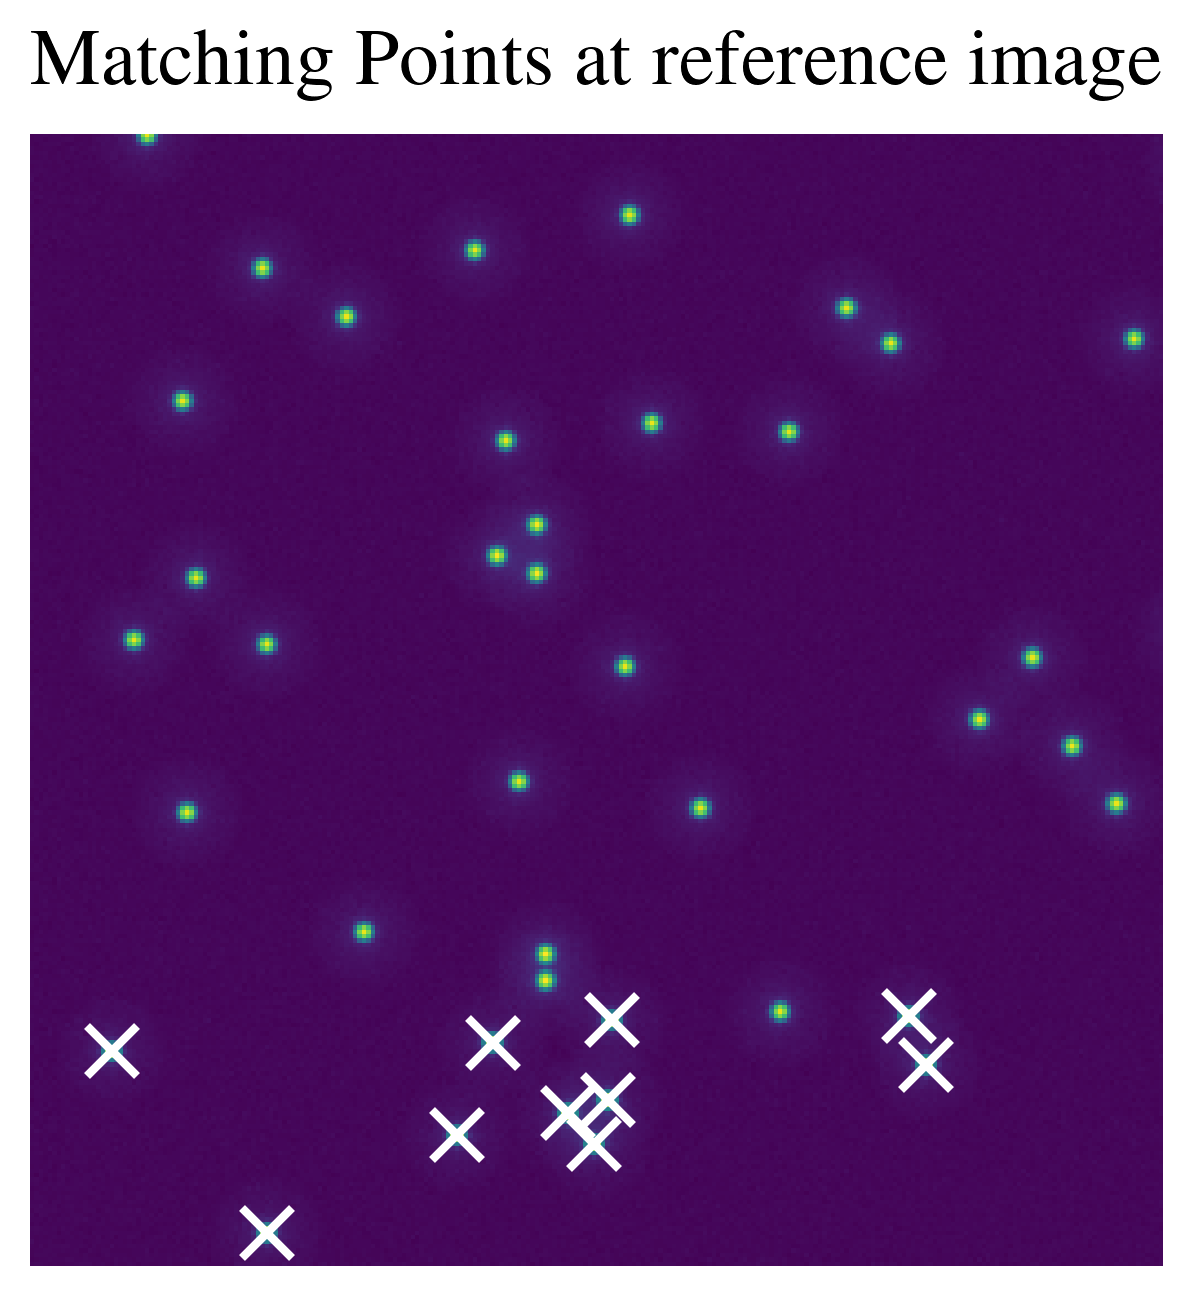

-------------------------------------------------------------------------


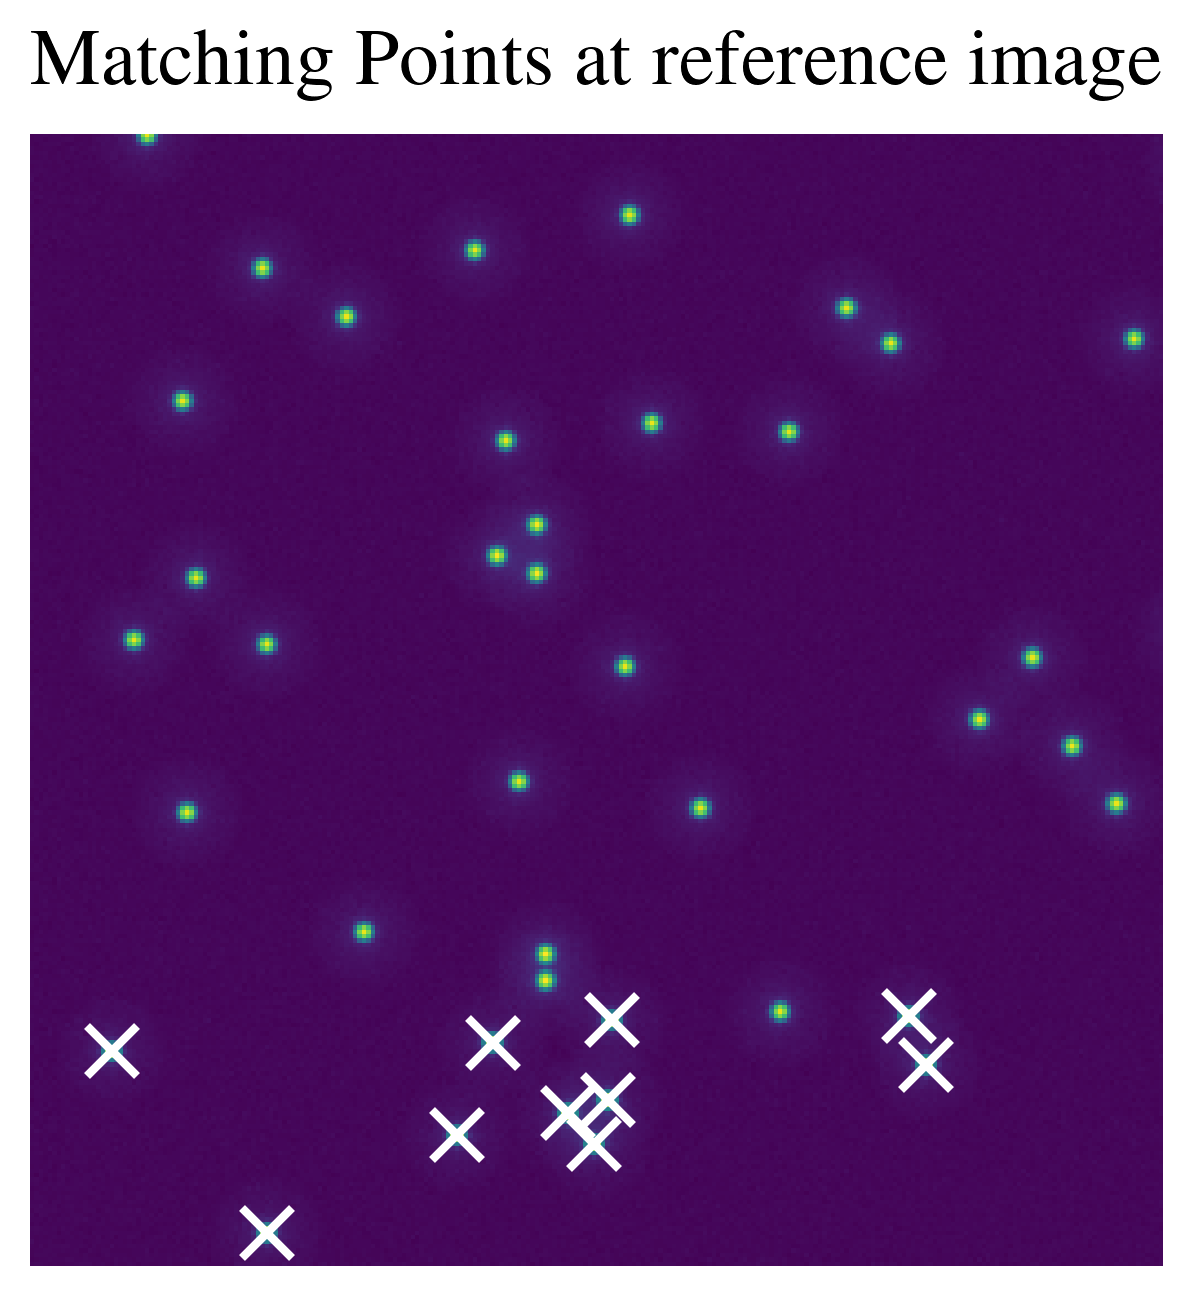

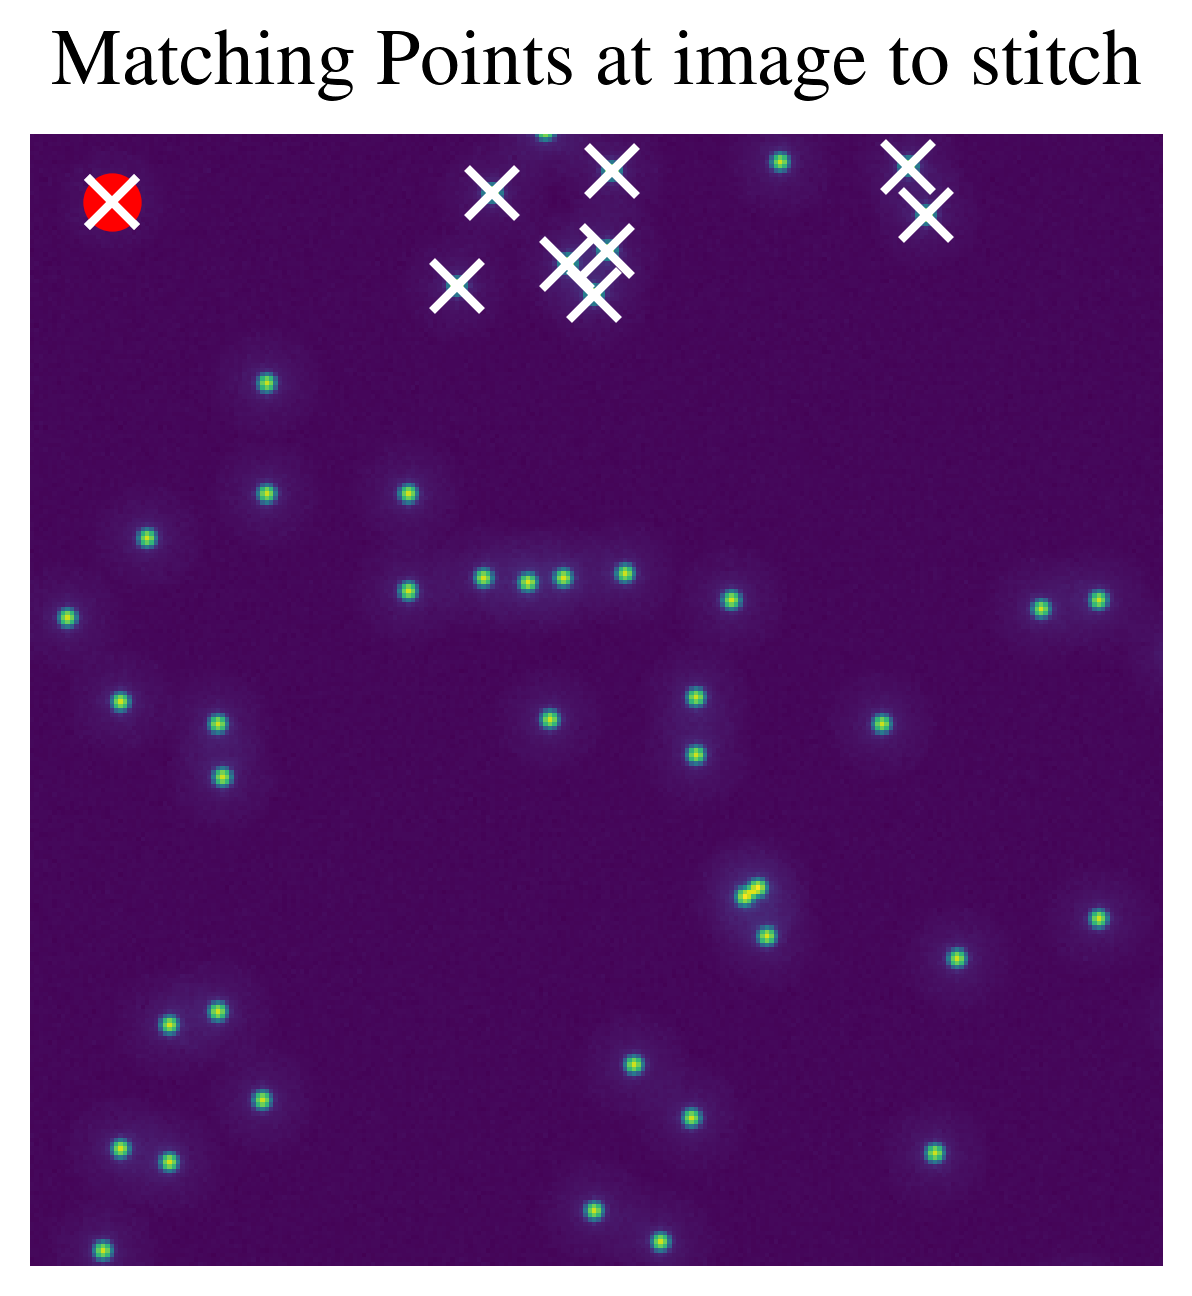

iterative stitch image dimension :  (448, 256)


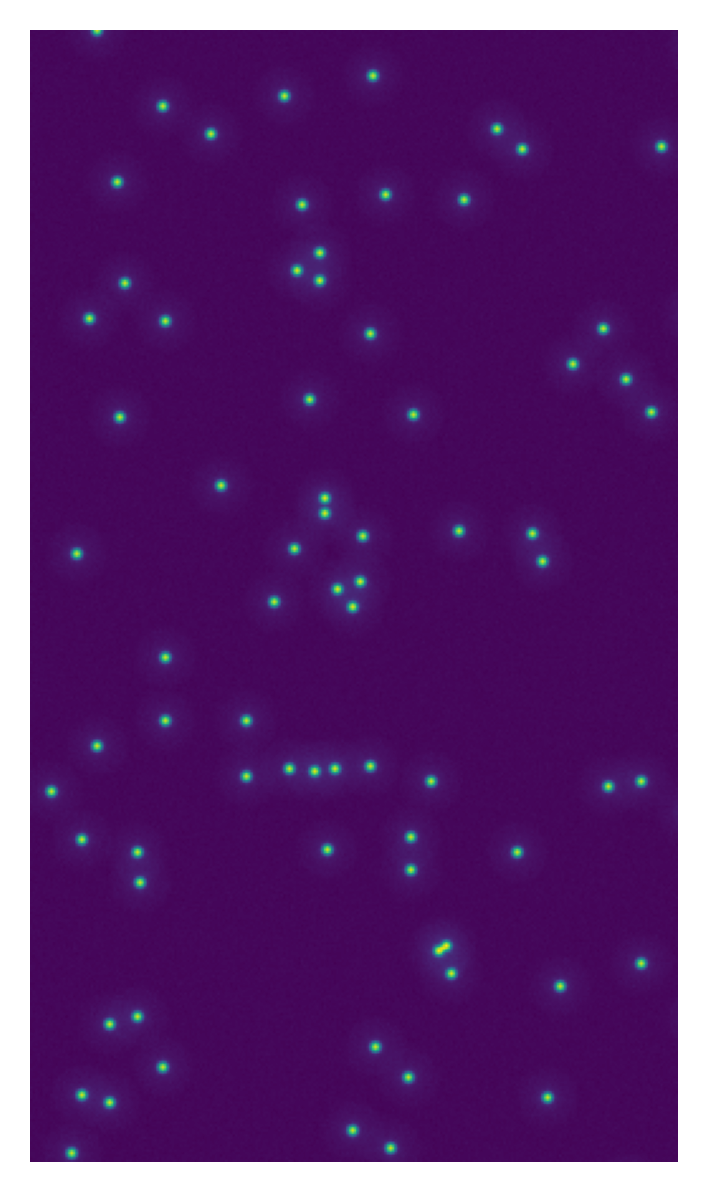

Number of particles detected = 39
Calculated fraction is 12
Manual input is 10
New fraction is 10
matching corners: shape = (2, 10, 2)
matching ssds: shape = (2, 10)
matching ssds: sum of values = 0.0
-------------------------------------------------------------------------
Number of iterations over matching corners == 2


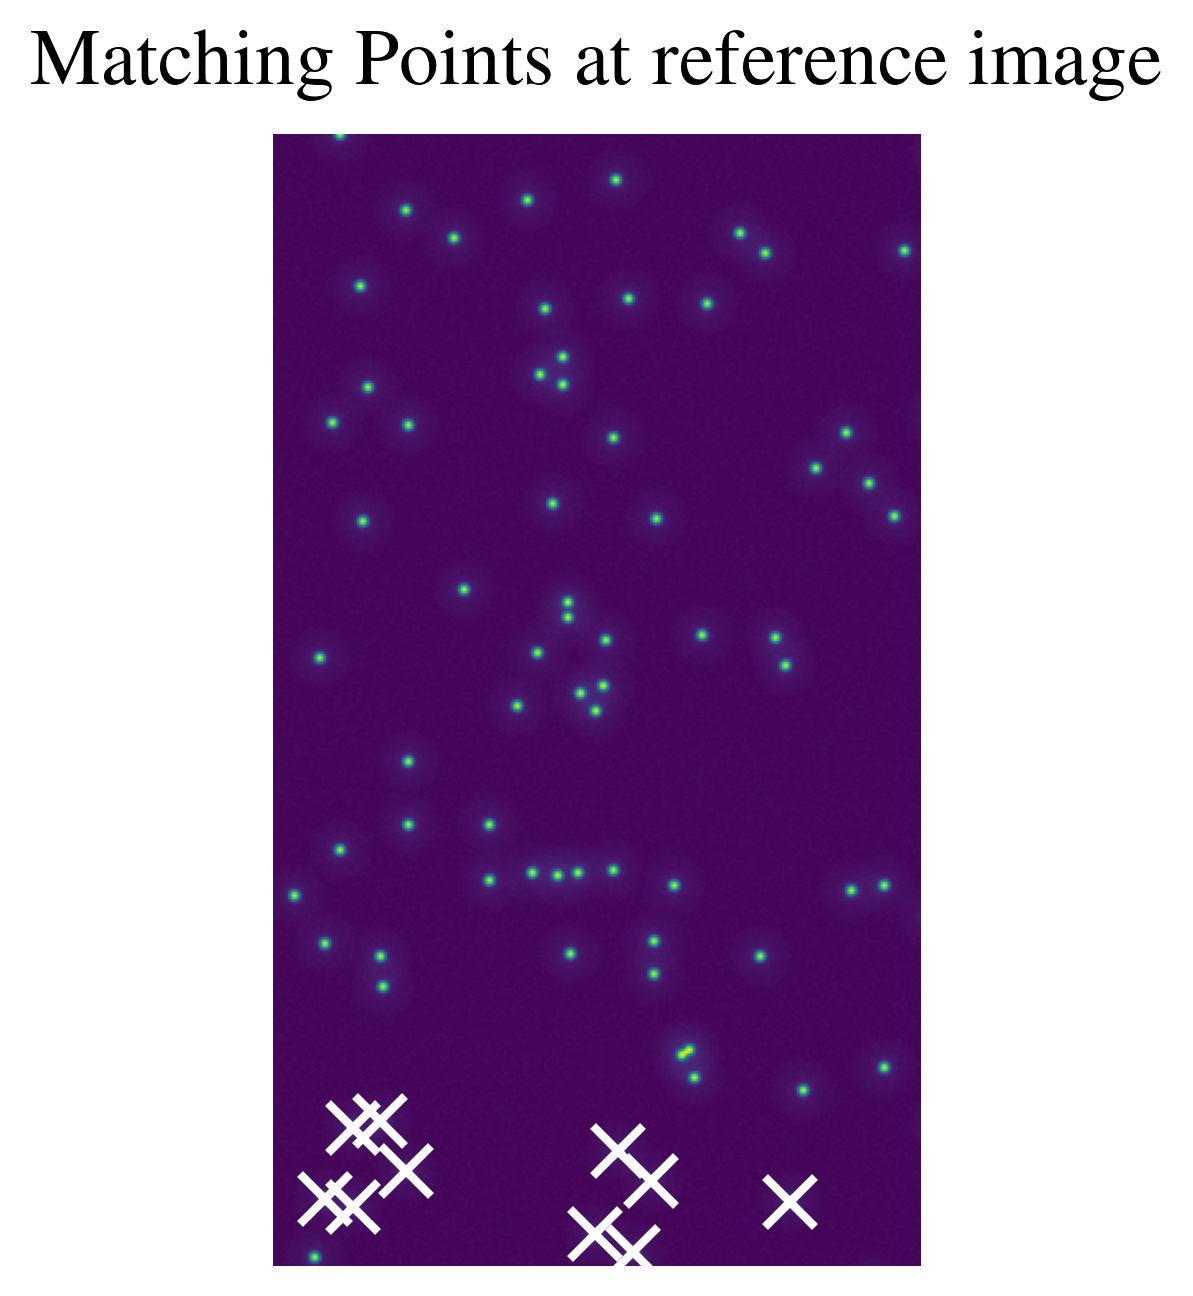

-------------------------------------------------------------------------


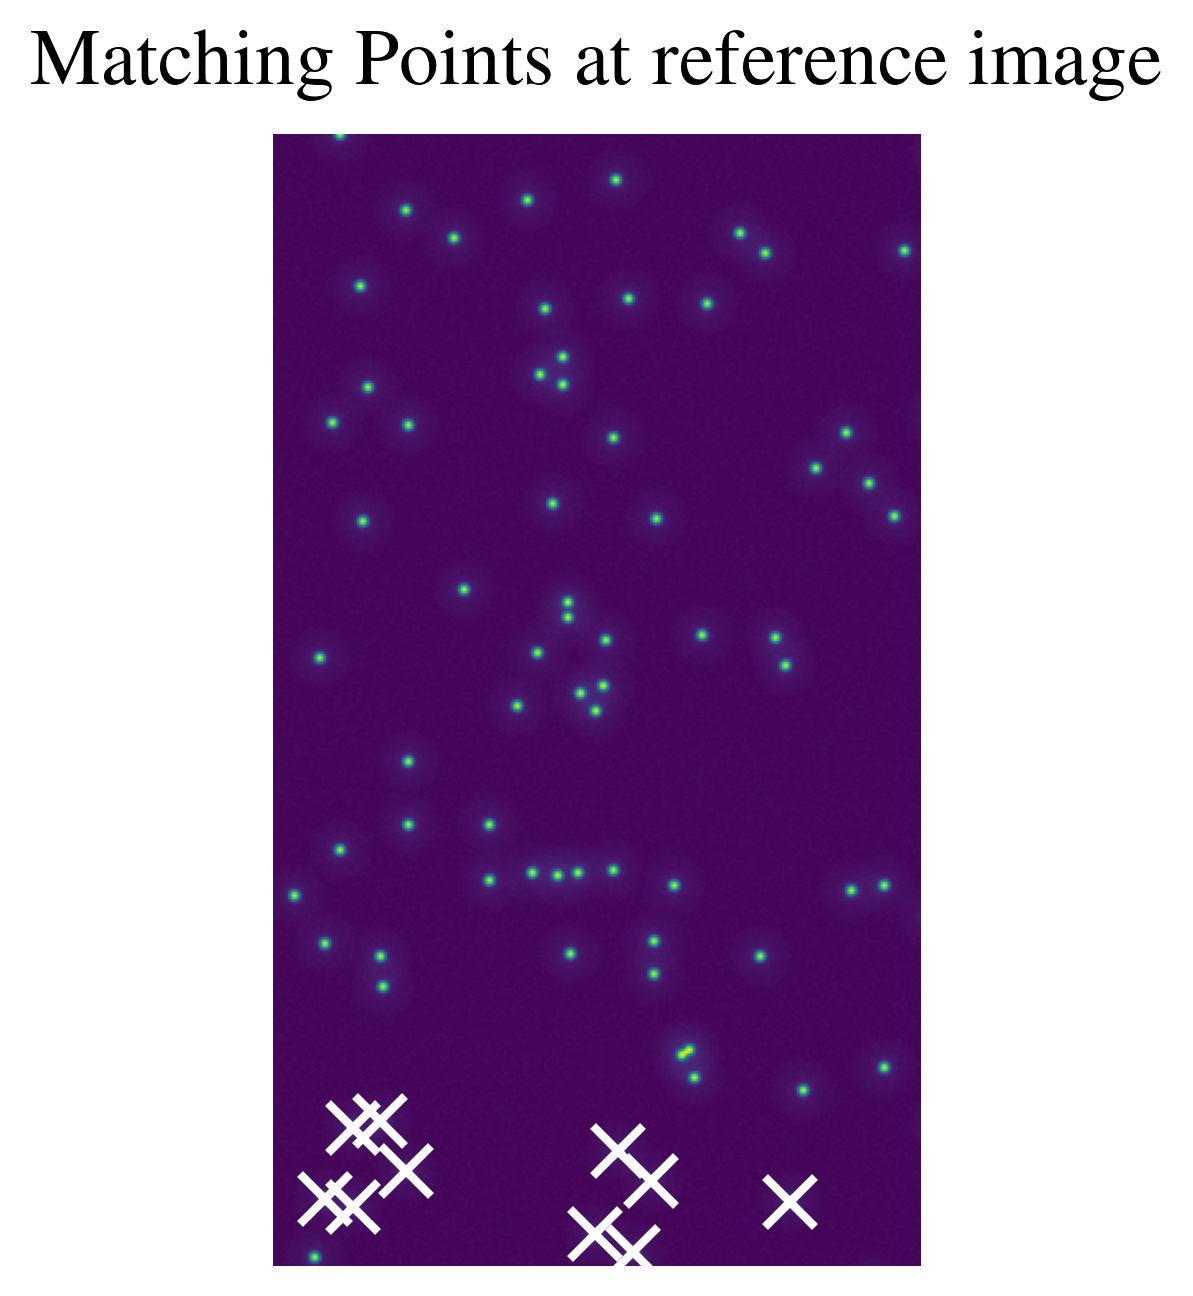

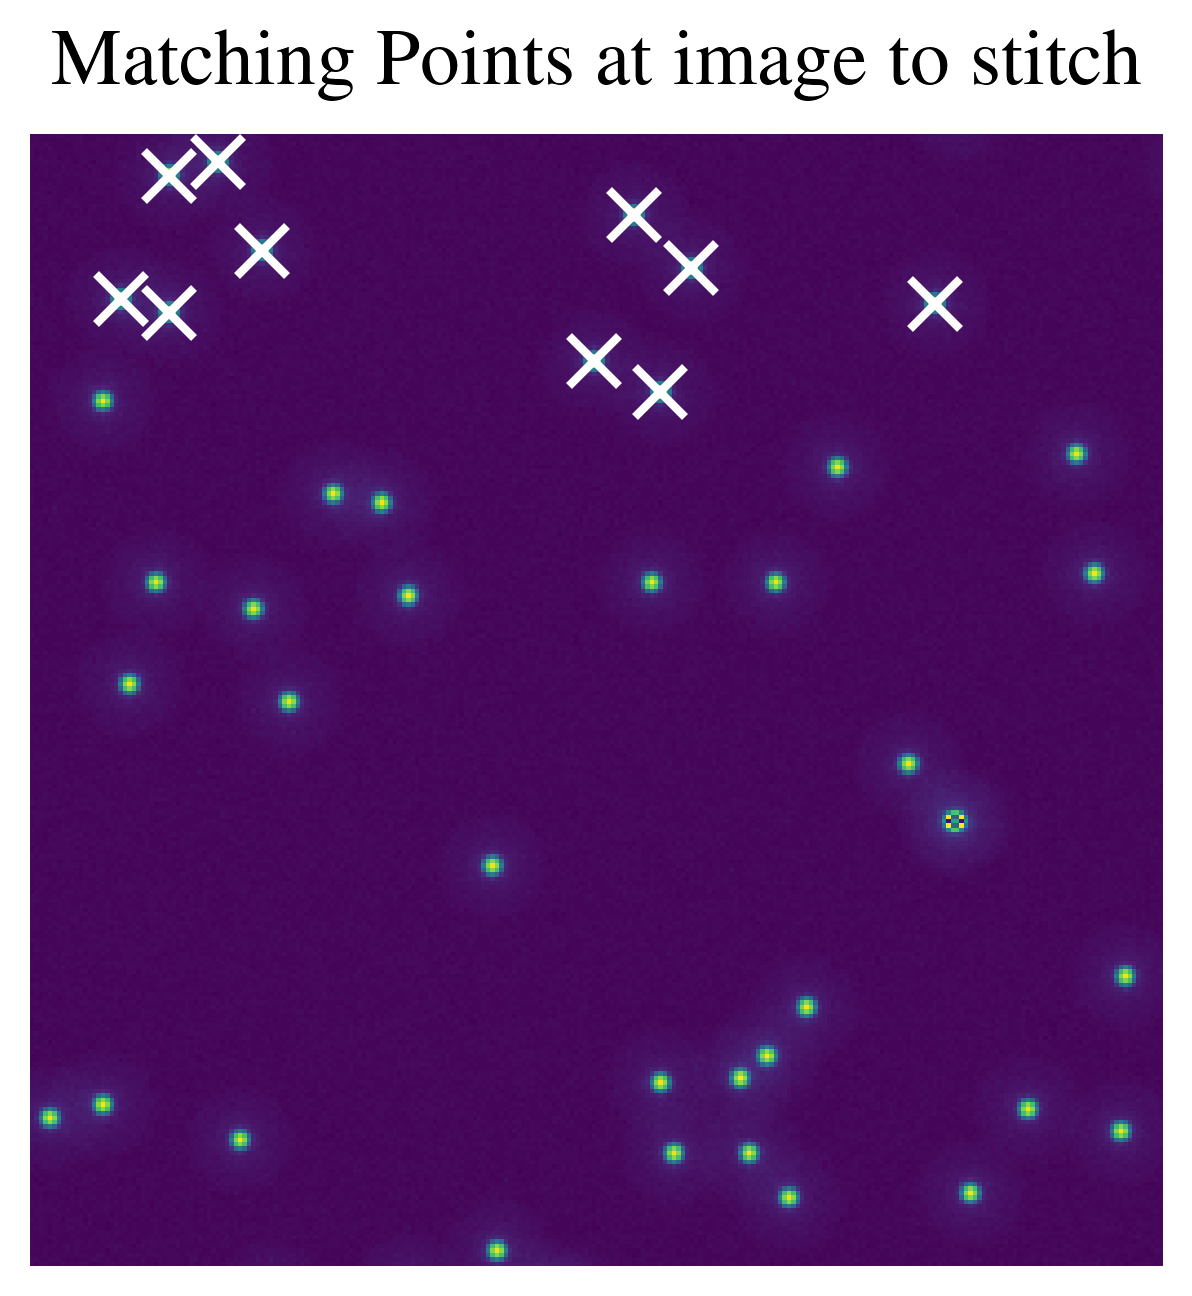

iterative stitch image dimension :  (640, 256)


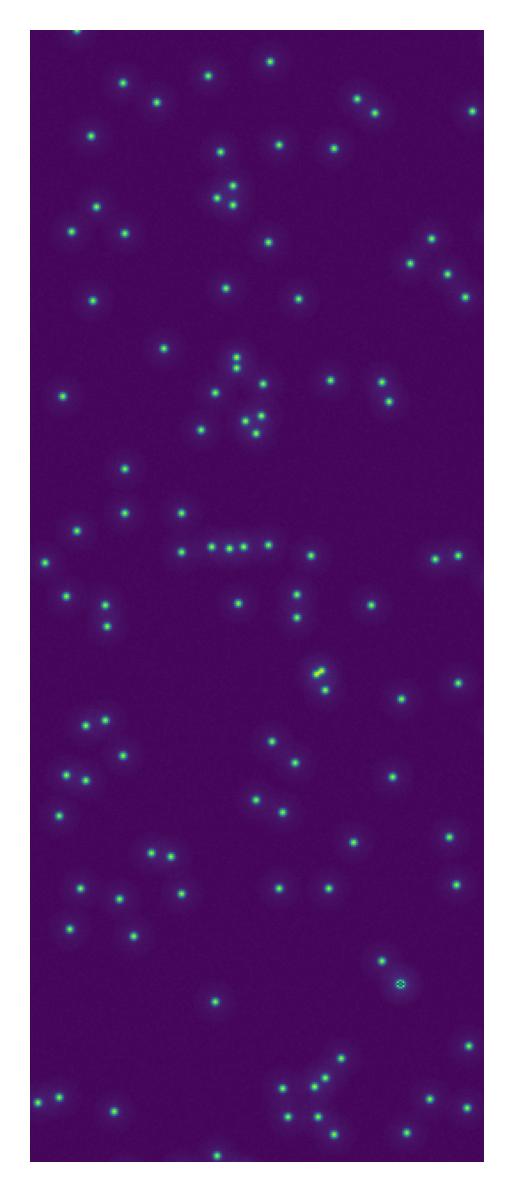

Number of particles detected = 42
Calculated fraction is 13
Manual input is 10
New fraction is 10
matching corners: shape = (2, 10, 2)
matching ssds: shape = (2, 10)
matching ssds: sum of values = 41533.489041337045
-------------------------------------------------------------------------
Number of iterations over matching corners == 2


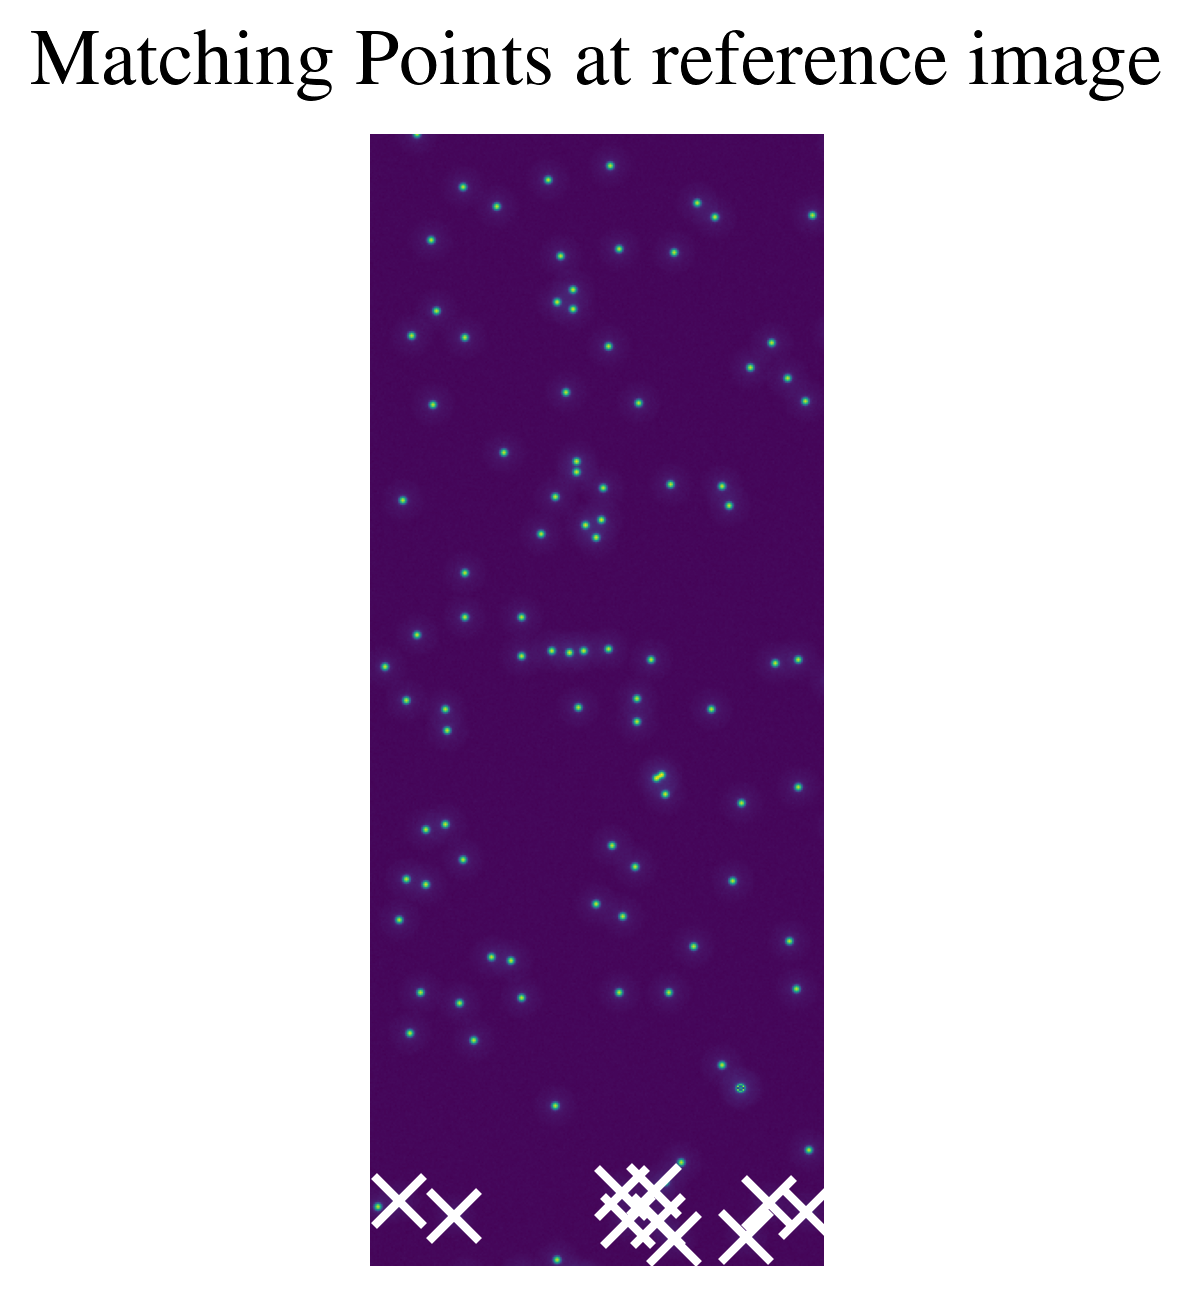

-------------------------------------------------------------------------


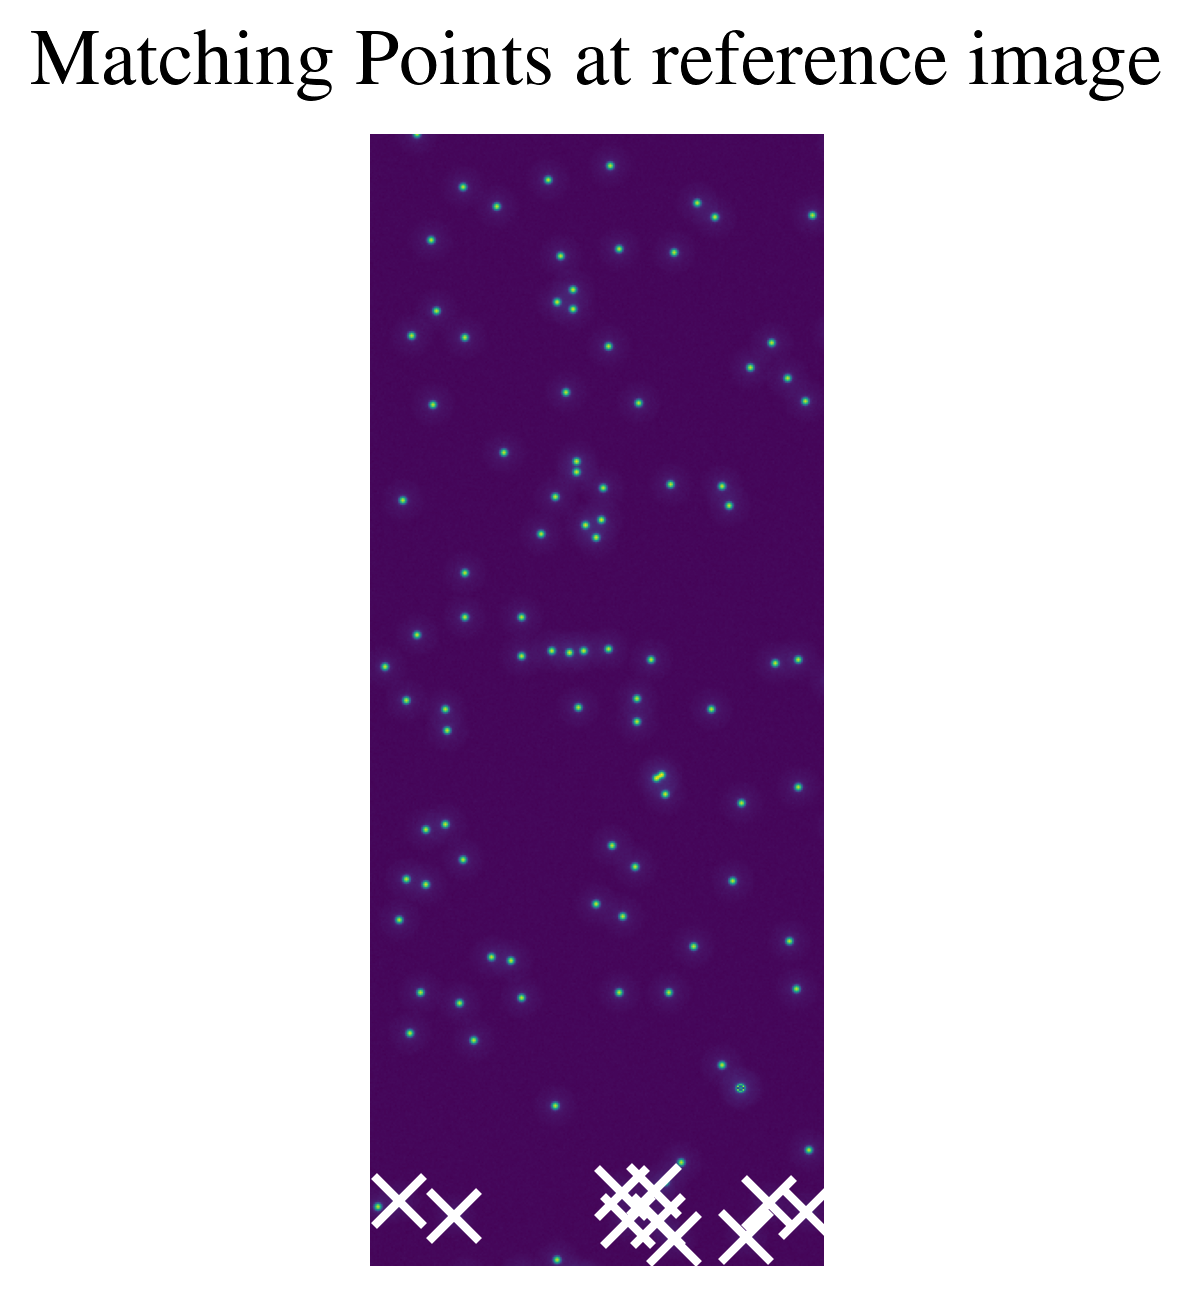

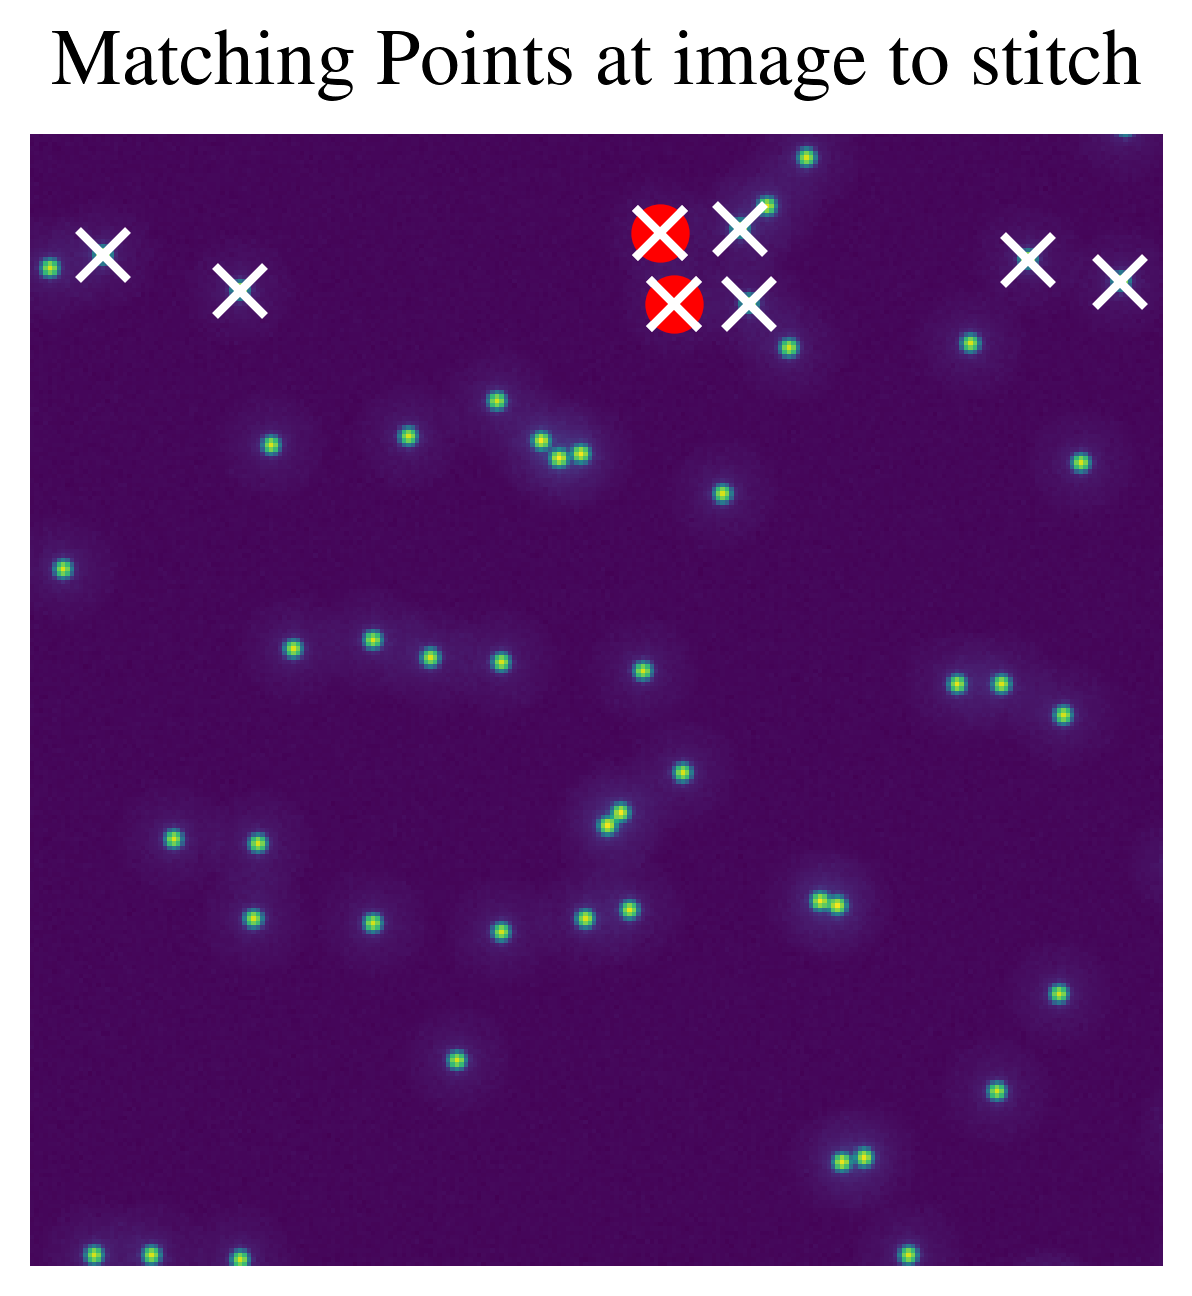

iterative stitch image dimension :  (832, 256)


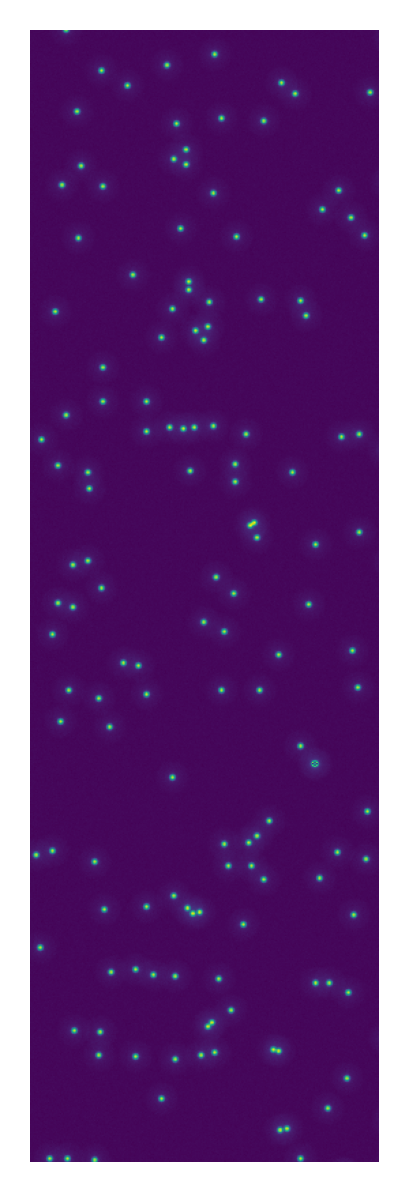

Number of particles detected = 44
Calculated fraction is 13
Manual input is 10
New fraction is 10
matching corners: shape = (2, 10, 2)
matching ssds: shape = (2, 10)
matching ssds: sum of values = 148800.90795450643
-------------------------------------------------------------------------
Number of iterations over matching corners == 2


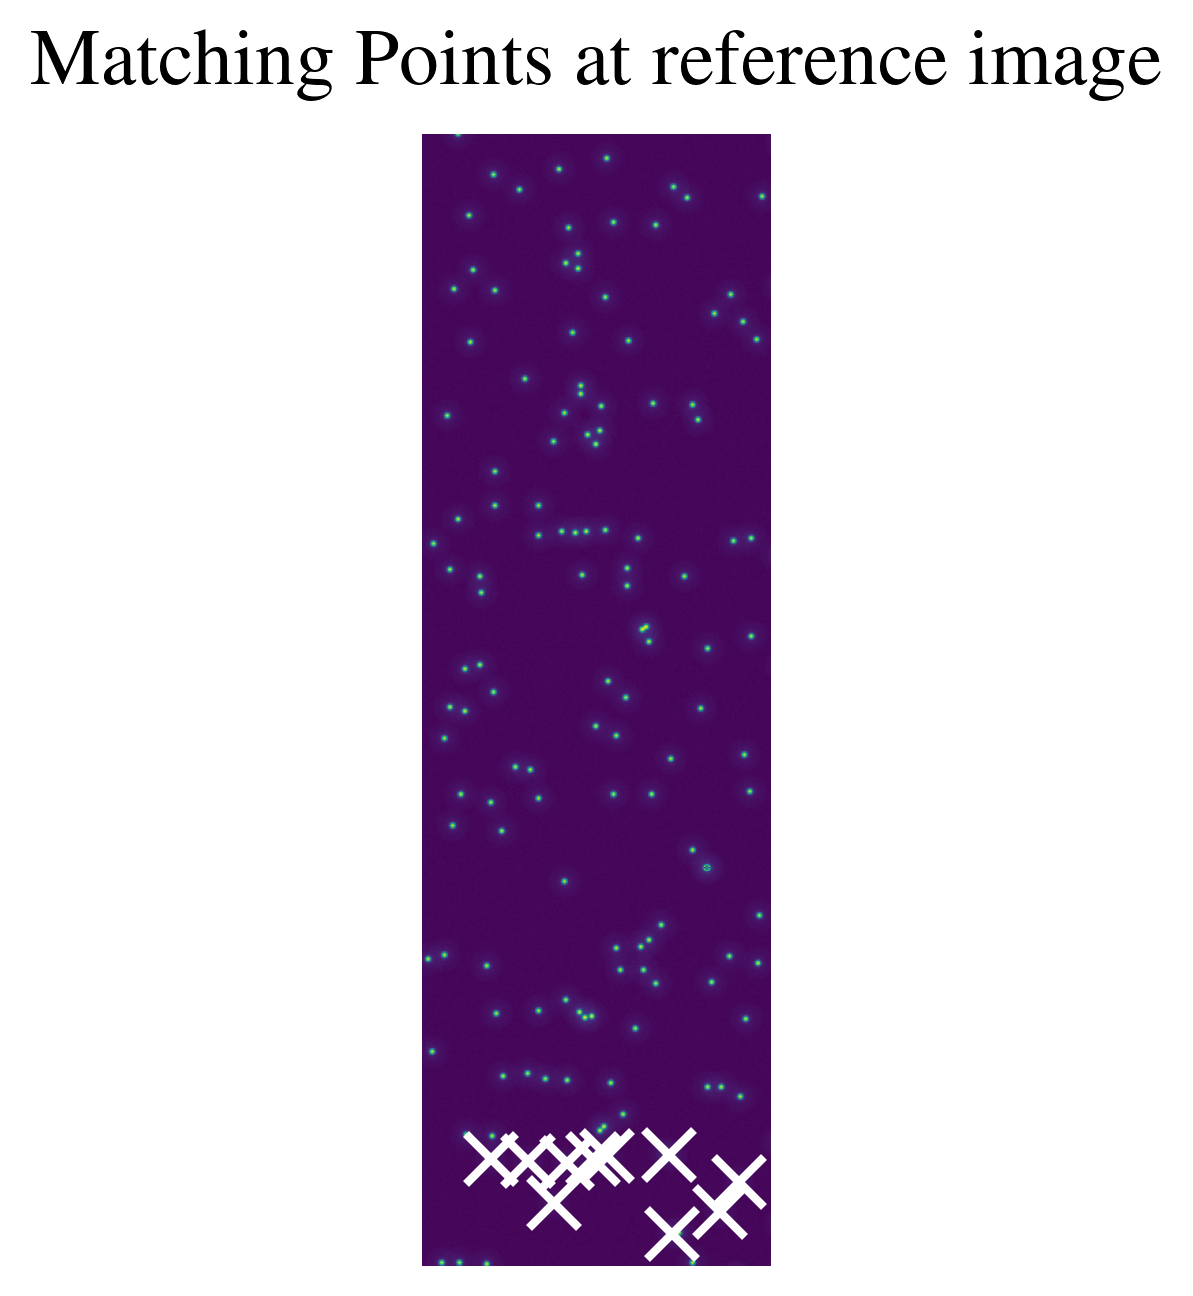

-------------------------------------------------------------------------


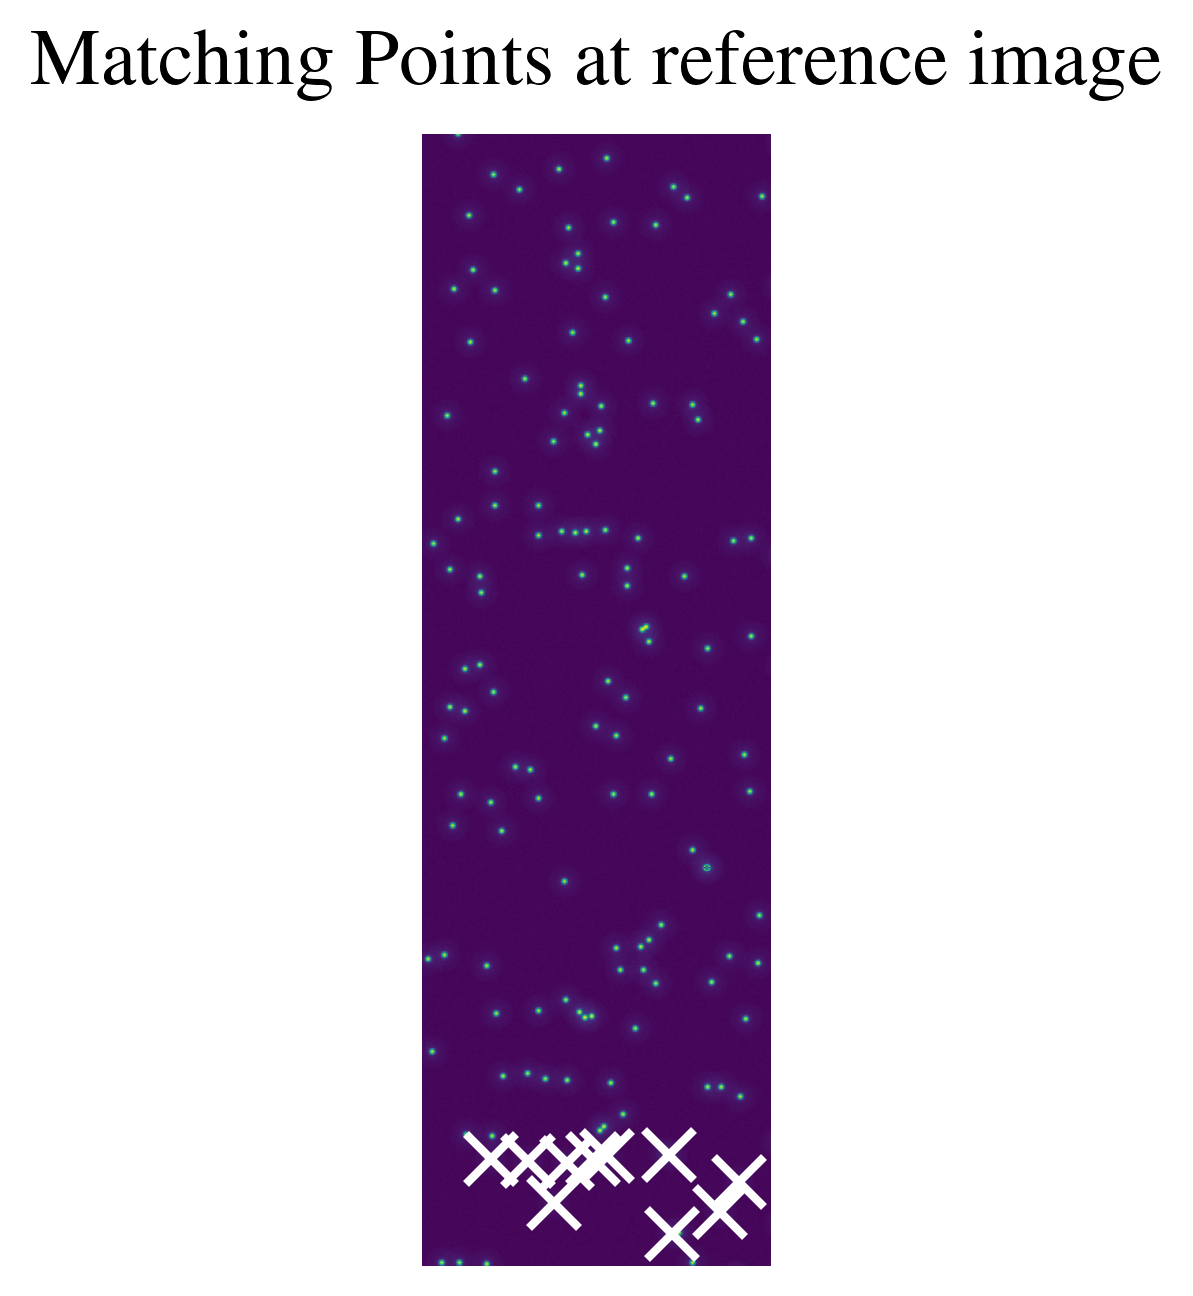

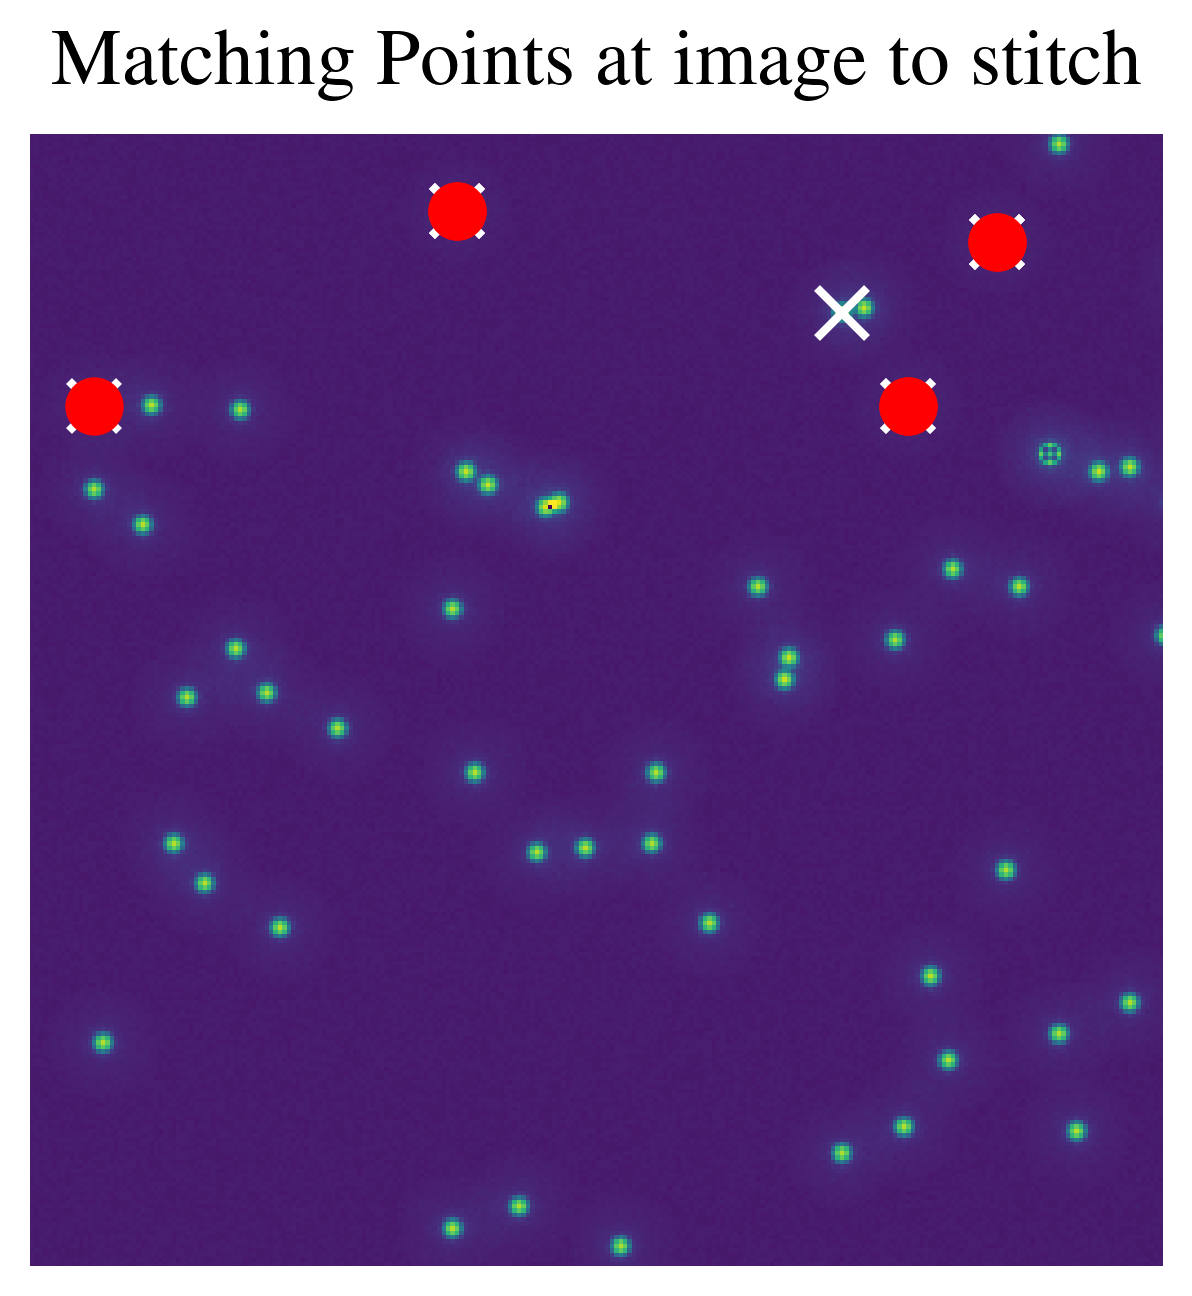

iterative stitch image dimension :  (1024, 256)


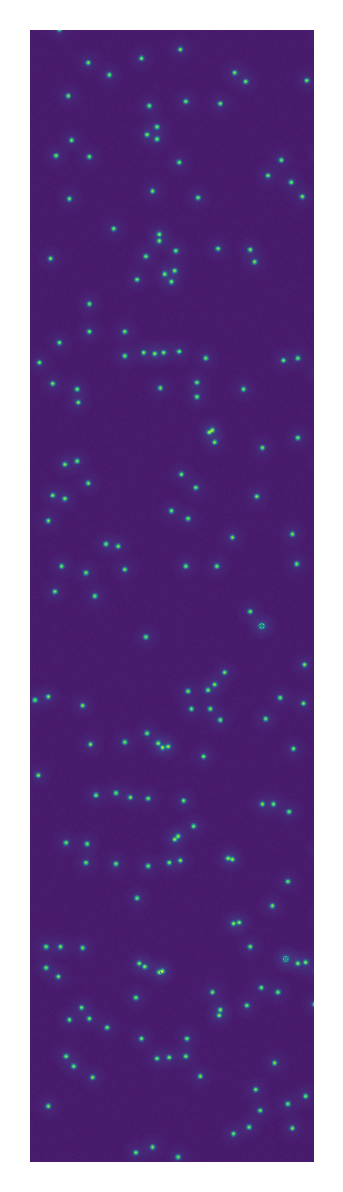

In [267]:

# image inputs
fp = '/Users/mackenzie/Desktop/ece278a/skimage/full_field/overlap_{}percent'.format(true_percent_overlap)

if direction == "H":
    # horizontal
    path1 = join(fp, 'image_i0_j4.tif')
    path2 = join(fp, 'image_i1_j4.tif')
    path3 = join(fp, 'image_i2_j4.tif')
    path4 = join(fp, 'image_i3_j4.tif')
    path5 = join(fp, 'image_i4_j4.tif')
    path6 = join(fp, 'image_i5_j4.tif')
    path7 = join(fp, 'image_i6_j4.tif') 
if direction == "V":    
    # vertical
    path1 = join(fp, 'image_i0_j0.tif')
    path2 = join(fp, 'image_i0_j1.tif')
    path3 = join(fp, 'image_i0_j2.tif')
    path4 = join(fp, 'image_i0_j3.tif')
    path5 = join(fp, 'image_i0_j4.tif')
    path6 = join(fp, 'image_i0_j5.tif')
    path7 = join(fp, 'image_i0_j6.tif')

# Open the image form working directory
img_list = []

image = Image.open(path1)
img = np.array(image)
img_list.append(img)
image = Image.open(path2)
img = np.array(image)
img_list.append(img)
image = Image.open(path3)
img = np.array(image)
img_list.append(img)
image = Image.open(path4)
img = np.array(image)
img_list.append(img)
image = Image.open(path5)
img = np.array(image)
img_list.append(img)

# main program
# stitch the image iterativly

while(len(img_list)>=2):
    
    # ----------------------- STEP 1: DETECT PARTICLES -----------------------
    corner_list = []
    for i in range(0,2,1):
        if harris_detector:
            corner_list.append(feature.corner_peaks(feature.corner_harris(img_list[i]), 
                                                    threshold_rel=0.001, 
                                                    min_distance=min_dist))
            input_detector = 'Harris'
            
        if hessian_detector:
            corner_list.append(feature.corner_peaks(feature.hessian_matrix_det(img_list[i]), 
                                                    threshold_rel=0.2, 
                                                    min_distance=min_dist))
            input_detector = 'Hessian'
            
        if DoG_detector:
            # Edit by Sean:
                # high_sigma: from skimage.difference_of_gaussians notes, high_sigma is generally 1.6X low sigma.
                # Sean changed high_sigma from 2.6 to 3.2 to use the suggested low_sigma*1.6 ratio.
            corner_list.append(feature.corner_peaks(difference_of_gaussians(image=img_list[i],
                                                                            low_sigma=2,
                                                                            high_sigma=3.2), 
                                                    threshold_rel=0.6, 
                                                    min_distance=min_dist))
            input_detector = 'DoG'
            
        """
        Functions:
            Difference of Gaussians:
                Method: This function will subtract an array filtered with a Gaussian kernel with sigmas given by 
                high_sigma from an array filtered with a Gaussian kernel with sigmas provided by low_sigma. 
                Note: When high_sigma is none, the values for high_sigma will be calculated as 1.6x the corresponding
                values in low_sigma. This ratio was originally proposed by Marr and Hildreth (1980) [1] and is 
                commonly used when approximating the inverted Laplacian of Gaussian, which is used in edge and blob detection.
            Corner Peaks:
                Find peaks in corner measure response image.
                min_distance: minimal allowed distance separating peaks.
        """

    
    # ----------------------- STEP 2: SORT PARTICLES BY LOCATION -----------------------
    
    if direction == "H":
        # horizontally
        corner_list[0] = sorted(corner_list[0],key=lambda s:s[1], reverse=True )
        corner_list[1] = sorted(corner_list[1],key=lambda s:s[1])
    
    if direction == "V":
        # vertically
        corner_list[0] = sorted(corner_list[0],key=lambda s:s[0], reverse=True )
        corner_list[1] = sorted(corner_list[1],key=lambda s:s[0])


    # ----------------------- STEP 3: KEY POINT SELECTION -----------------------
    
    """
    IMPORTANT NOTE
    
    Keypoint matching can be performed using:
        (1) fraction (integer == num particles): A fraction of the total number of particle detected
        (2) manual_input (integer == num particles): A defined number of particles detected
    """
    
    fraction = int(len(corner_list[1])/denominate_faction)+1
    print("Number of particles detected = {}".format(len(corner_list[1])))
    print("Calculated fraction is {}".format(fraction))
    # corner_list: is the detector output
    # denominate_fraction: is the user inputted fraction of particles we want to match on 
    # fraction: 
    
    fraction = manual_input
    
    print("Manual input is {}".format(manual_input))
    print("New fraction is {}".format(fraction))
    
    img0 = img_list[0]
    # coords0 = corner_list[0][0:fraction]
    coords0 = corner_list[0][0:manual_input]

    
    # ----------------------- STEP 4: KEY POINT MATCHING -----------------------
    
    matching_corners=[]
    matching_ssds=[]
    for i in range(0,2,1):
        matched_corners, matched_corner_ssds = match_locations(img0, 
                                                               img_list[i], 
                                                               coords0, 
                                                               corner_list[i][0:fraction], 
                                                               min_dist)
        matching_corners.append(matched_corners)
        matching_ssds.append(matched_corner_ssds)

    
    # ----------------------- STEP 5: RESULTS VISUALIZATION -----------------------
    print("matching corners: shape = {}".format(np.shape(matching_corners)))
    # matching corners: [image #, particle x coord., particle y coord]
    print("matching ssds: shape = {}".format(np.shape(matching_ssds)))
    # matching ssds: [image #, SSD of particle at that index]
    # print("matching corners: values = {}".format(matching_corners))
    print("matching ssds: sum of values = {}".format(np.sum(matching_ssds)))
    
    print("-------------------------------------------------------------------------")
    fig, ax = plt.subplots()
    ax.imshow(img_list[0])
    
    print("Number of iterations over matching corners == {}".format(len(matching_corners)))
    for i in range(np.shape(matching_corners)[1]):
        plt.plot(matching_corners[0][i][1], matching_corners[0][i][0],"xw")
        
        # evaluate bad matches
        # print("Matching SSD of index, {}: = {}".format(i, matching_ssds[0][i]))
        if matching_ssds[0][i] > 1:
            plt.plot(matching_corners[0][i][1], matching_corners[0][i][0],"or")
        
    plt.title("Matching Points at reference image ")
    plt.axis("off")
    plt.show()
    print("-------------------------------------------------------------------------")
    
    # show the match points
    if show_keypoints_extract_infor and show_iterative_result:
        # r : Harris Detector
        # y : Hessian Detector
        # w : Difference of Gaussians (DoG)
        
        # OPTIONAL: help understand
        fig5, ax5 = plt.subplots()
        ax5.imshow(img_list[0])
        for i in range(fraction):
            plt.plot(corner_list[0][i][1],corner_list[0][i][0],"xw")
            
        plt.title("keypoints_extract : Difference of Gaussians (DoG)")
        plt.axis("off")
        plt.show()

        fig6, ax6 = plt.subplots()
        ax6.imshow(img_list[1])
        for i in range(fraction):
            plt.plot(corner_list[1][i][1],corner_list[1][i][0],"xw")
        
        plt.title("keypoints_extract : Difference of Gaussians (DoG)")
        plt.axis("off")
        plt.show()
    
    if show_match_points_infor and show_iterative_result:
        fig7, ax7 = plt.subplots()
        ax7.imshow(img_list[0])
        for i in range(fraction):
            plt.plot(matching_corners[0][i][1],matching_corners[0][i][0],"xw")
            
            # evaluate bad matches
            #print("Matching SSD of index, {}: = {}".format(i, matching_ssds[0][i]))
            if matching_ssds[0][i] > 1:
                plt.plot(matching_corners[0][i][1], matching_corners[0][i][0],"or")
        
        plt.title("Matching Points at reference image ")
        plt.axis("off")
        plt.show()

        fig8, ax8 = plt.subplots()
        ax8.imshow(img_list[1])
        for i in range(fraction):
            plt.plot(matching_corners[1][i][1],matching_corners[1][i][0],"xw")
                    
            # evaluate bad matches
            # print("Matching SSD of index, {}: = {}".format(i, matching_ssds[1][i]))
            if matching_ssds[1][i] > 1:
                plt.plot(matching_corners[1][i][1], matching_corners[1][i][0],"or")
        
        plt.title("Matching Points at image to stitch")
        plt.axis("off")
        plt.show()
    
    
    # call self-develope function to stitch image
    sti, final_offset, diff = stitched_img(img_list[1],img_list[0],matching_corners[1],matching_corners[0],direction)
    
    if show_iterative_result:
        print("iterative stitch image dimension : ",sti.shape)
        plt.imshow(sti)
        plt.axis("off")
        plt.show()
        
    
    img_list[1] = sti
    # pop the image which has been merged into iterative stitch image
    img_list.pop(0)

stitch image dimension :  (1024, 256)


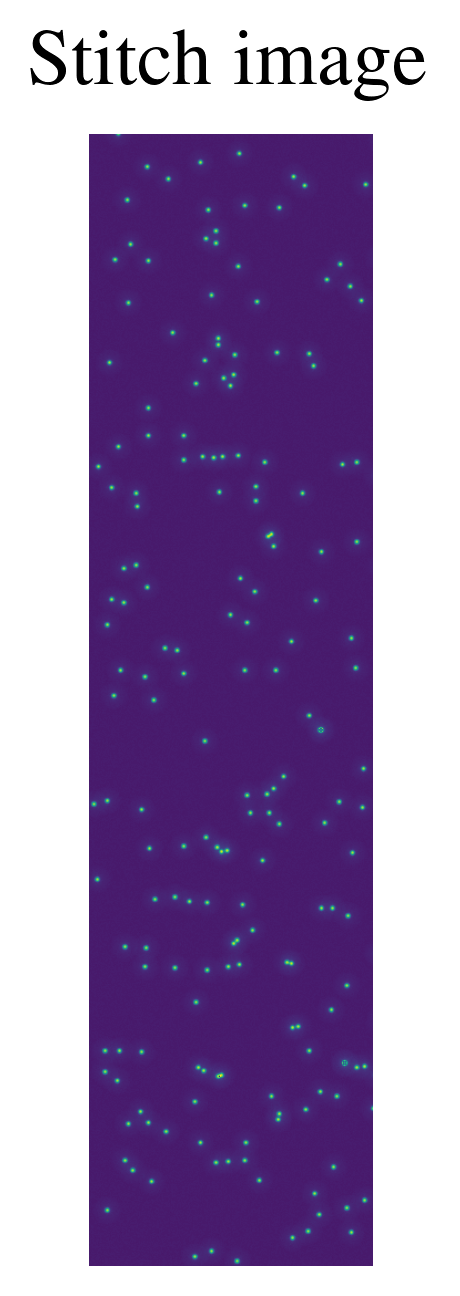

In [268]:
# main program
# show the fianl stitching result

plt.imshow(sti)
print("stitch image dimension : ",sti.shape)
plt.title("Stitch image")
plt.axis("off")
plt.show()